In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import lightkurve as lk
from astropy.timeseries import LombScargle
from scipy.signal import find_peaks, peak_widths
from mesagrid import Track
import mesa_reader as mr
# import pygyre as pg
import os
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy import units as u
from scipy.ndimage import median_filter, uniform_filter1d
%matplotlib inline

In [2]:
%config InlineBackend.figure_format='retina'
plt.rcParams.update({
    'axes.linewidth' : 1,
    'ytick.major.width' : 1,
    'ytick.minor.width' : 1,
    'xtick.major.width' : 1,
    'xtick.minor.width' : 1,
    'xtick.labelsize': 10, 
    'ytick.labelsize': 10,
    'axes.labelsize': 12,
    'font.family': 'serif',
    'text.usetex': False
})

In [3]:
ID = 'KIC 08626021'

In [4]:
lk = lk.search_lightcurve(f'{ID}', mission = 'Kepler', quarter=17)
lk

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,Kepler Quarter 17,2013,Kepler,60,kplr008626021,0.0
1,Kepler Quarter 17,2013,Kepler,60,kplr008626021,0.0
2,Kepler Quarter 17,2013,Kepler,1800,kplr008626021,0.0


In [41]:
lc = lk.download_all().stitch()
lc

time,flux,flux_err,quality,timecorr,centroid_col,centroid_row,cadenceno,sap_flux,sap_flux_err,sap_bkg,sap_bkg_err,pdcsap_flux,pdcsap_flux_err,sap_quality,psf_centr1,psf_centr1_err,psf_centr2,psf_centr2_err,mom_centr1,mom_centr1_err,mom_centr2,mom_centr2_err,pos_corr1,pos_corr2
,,,,d,pix,pix,,electron / s,electron / s,electron / s,electron / s,electron / s,electron / s,,pix,pix,pix,pix,pix,pix,pix,pix,pix,pix
Time,float32,float32,int32,float32,float64,float64,int32,float32,float32,float32,float32,float32,float32,int32,float64,float32,float64,float32,float64,float32,float64,float32,float32,float32
1559.21607148138,———,———,0,-9.562586e-04,103.07924,743.09795,2117740,2.2053014e+02,6.3817410e+00,2.1958955e+02,5.9037752e-02,———,———,0,———,———,———,———,103.07924,4.0390737e-02,743.09795,4.0585108e-02,-4.4436897e-03,1.2378150e-03
1559.2167527011115,9.8668164e-01,2.8454211e-02,0,-9.562389e-04,103.13471,743.18939,2117741,2.3370511e+02,6.5022888e+00,2.1958534e+02,5.9038643e-02,5.1967975e+02,1.4986675e+01,0,———,———,———,———,103.13471,4.0208921e-02,743.18939,4.0844843e-02,-4.4461638e-03,1.2382175e-03
1559.2174338208424,9.9152720e-01,2.8446333e-02,0,-9.562192e-04,103.05729,743.22708,2117742,2.3481705e+02,6.5007844e+00,2.1958112e+02,5.9039529e-02,5.2223187e+02,1.4982526e+01,0,———,———,———,———,103.05729,4.1220855e-02,743.22708,4.2809431e-02,-4.4486374e-03,1.2386198e-03
1559.2181149405224,9.7897792e-01,2.8188623e-02,10000000000000,-9.561995e-04,103.11959,743.15578,2117743,2.3188362e+02,6.4398603e+00,2.1957690e+02,5.9040420e-02,5.1562225e+02,1.4846792e+01,10000000000000,———,———,———,———,103.11959,4.0364604e-02,743.15578,4.0796354e-02,-4.4511114e-03,1.2390221e-03
1559.2187960602532,1.0072944e+00,2.8475093e-02,0,-9.561797e-04,103.12501,743.21948,2117744,2.3845665e+02,6.5082932e+00,2.1957269e+02,5.9041310e-02,5.3053638e+02,1.4997674e+01,0,———,———,———,———,103.12501,4.0240321e-02,743.21948,4.1307274e-02,-4.4535850e-03,1.2394246e-03
1559.2194772799849,1.0091982e+00,2.8472221e-02,0,-9.561600e-04,103.17597,743.19976,2117745,2.3888669e+02,6.5079165e+00,2.1956847e+02,5.9042197e-02,5.3153912e+02,1.4996161e+01,0,———,———,———,———,103.17597,4.1307323e-02,743.19976,4.1721694e-02,-4.4560591e-03,1.2398270e-03
1559.2201582996568,9.8532218e-01,2.8446363e-02,0,-9.561403e-04,103.05103,743.15173,2117746,2.3332089e+02,6.5020571e+00,2.1956425e+02,5.9043087e-02,5.1896375e+02,1.4982542e+01,0,———,———,———,———,103.05103,4.0468387e-02,743.15173,4.1177012e-02,-4.4585322e-03,1.2402294e-03
1559.2208394193876,9.5202690e-01,2.7984528e-02,0,-9.561206e-04,103.15597,743.17078,2117747,2.2556485e+02,6.3925323e+00,2.1956003e+02,5.9043974e-02,5.0142731e+02,1.4739296e+01,0,———,———,———,———,103.15597,4.1452959e-02,743.17078,4.1723065e-02,-4.4610058e-03,1.2406317e-03


<Axes: xlabel='Time - 2454833 [BKJD days]', ylabel='Normalized Flux'>

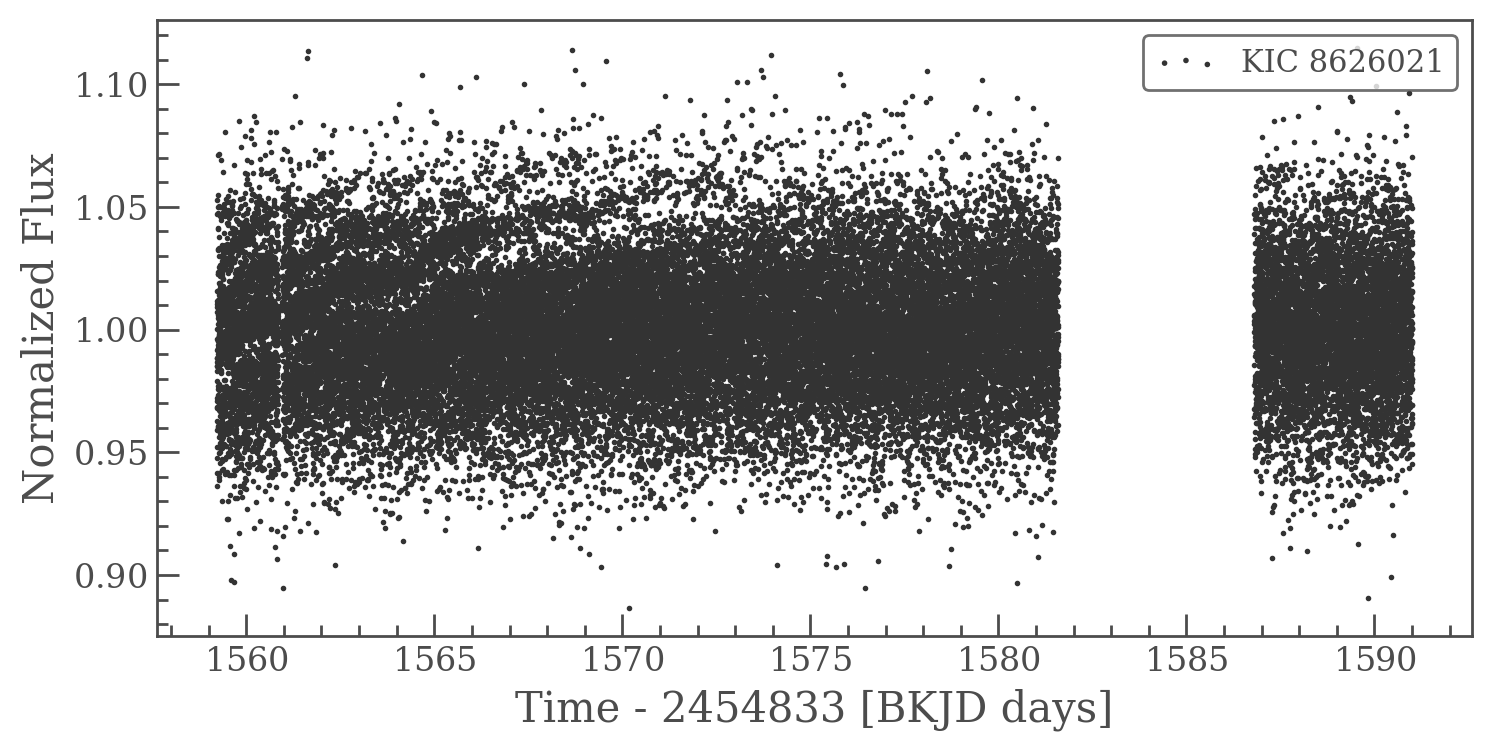

In [42]:
lc = lc.remove_outliers()
lc.scatter()

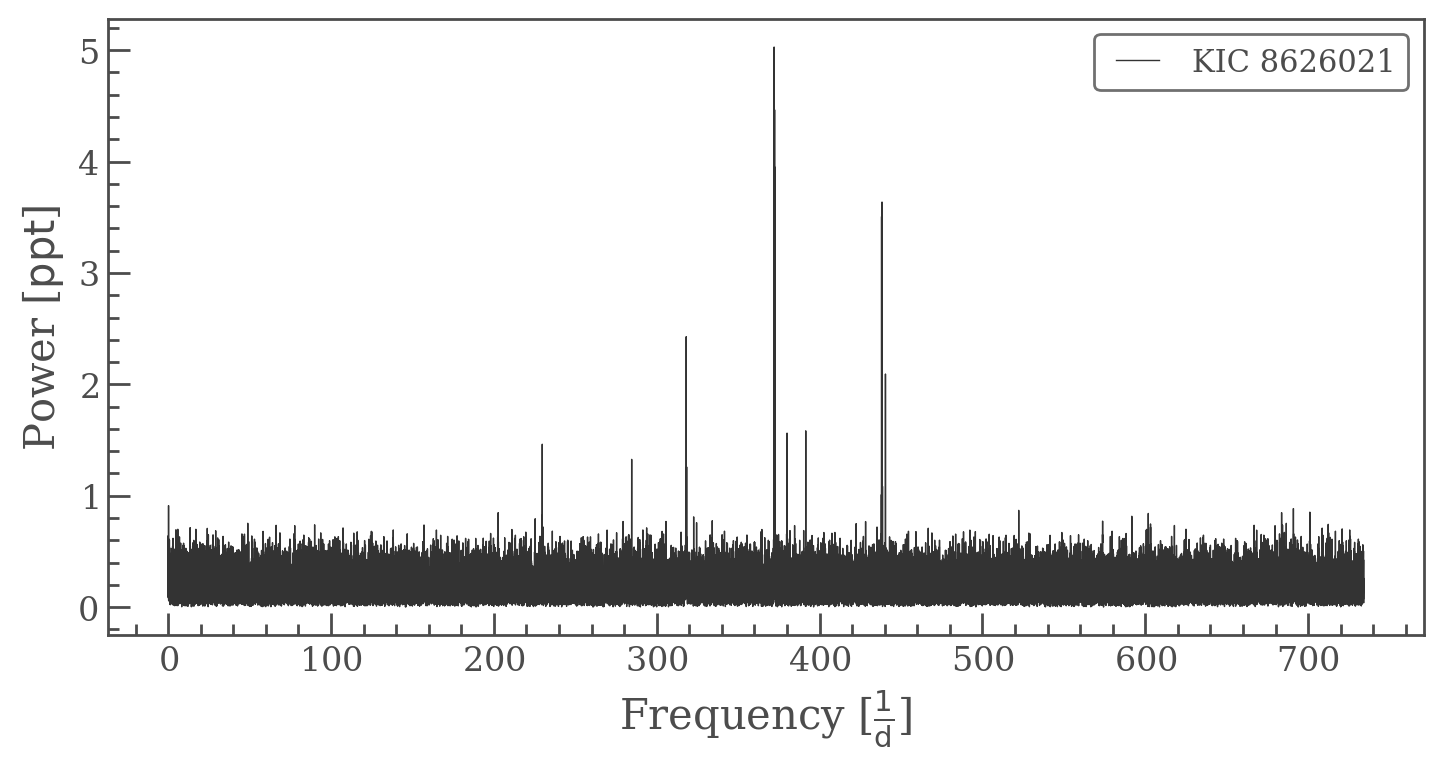

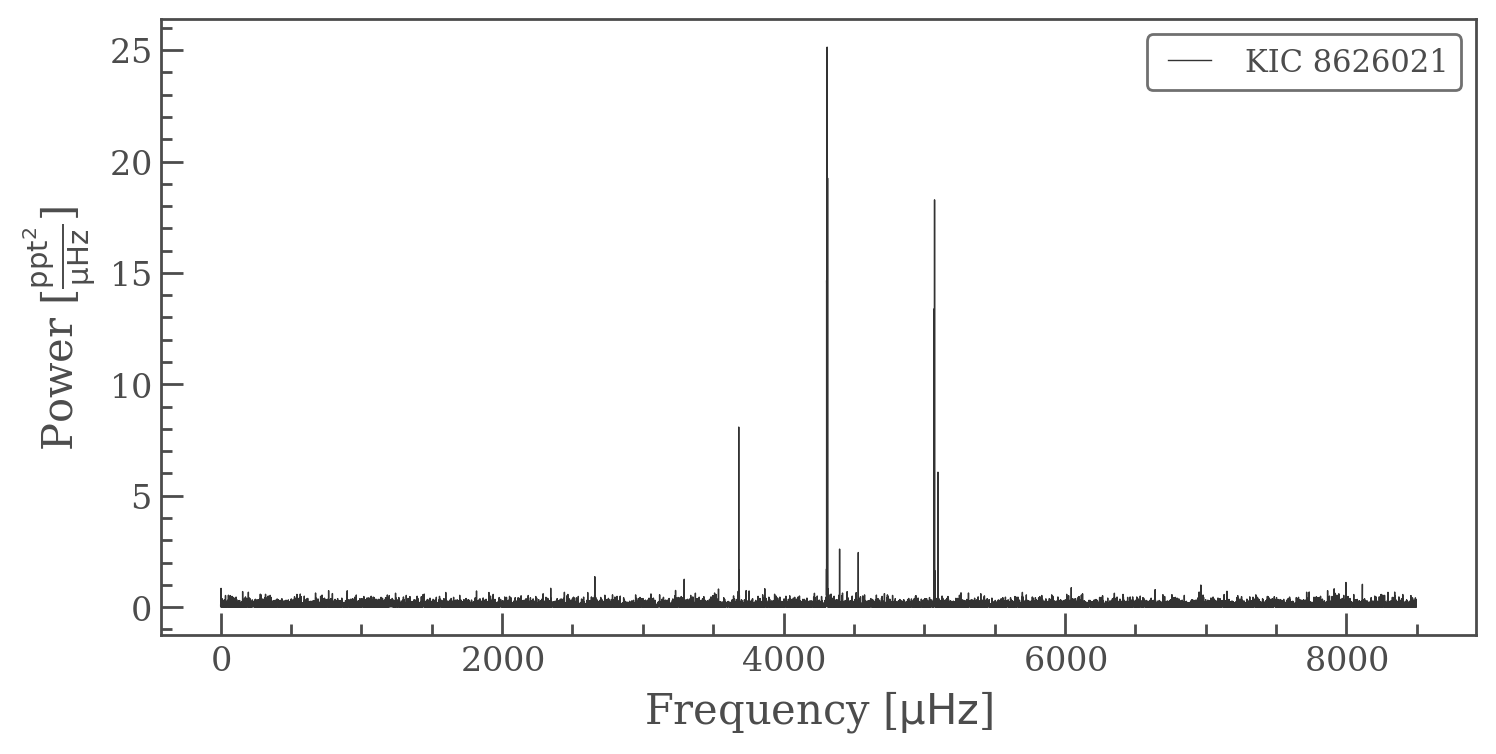

In [43]:
pg = lc.normalize(unit = 'ppt').to_periodogram()#normalization = 'psd')
pg.plot();
pg = lc.normalize(unit = 'ppt').to_periodogram(normalization = 'psd')
pg.plot();

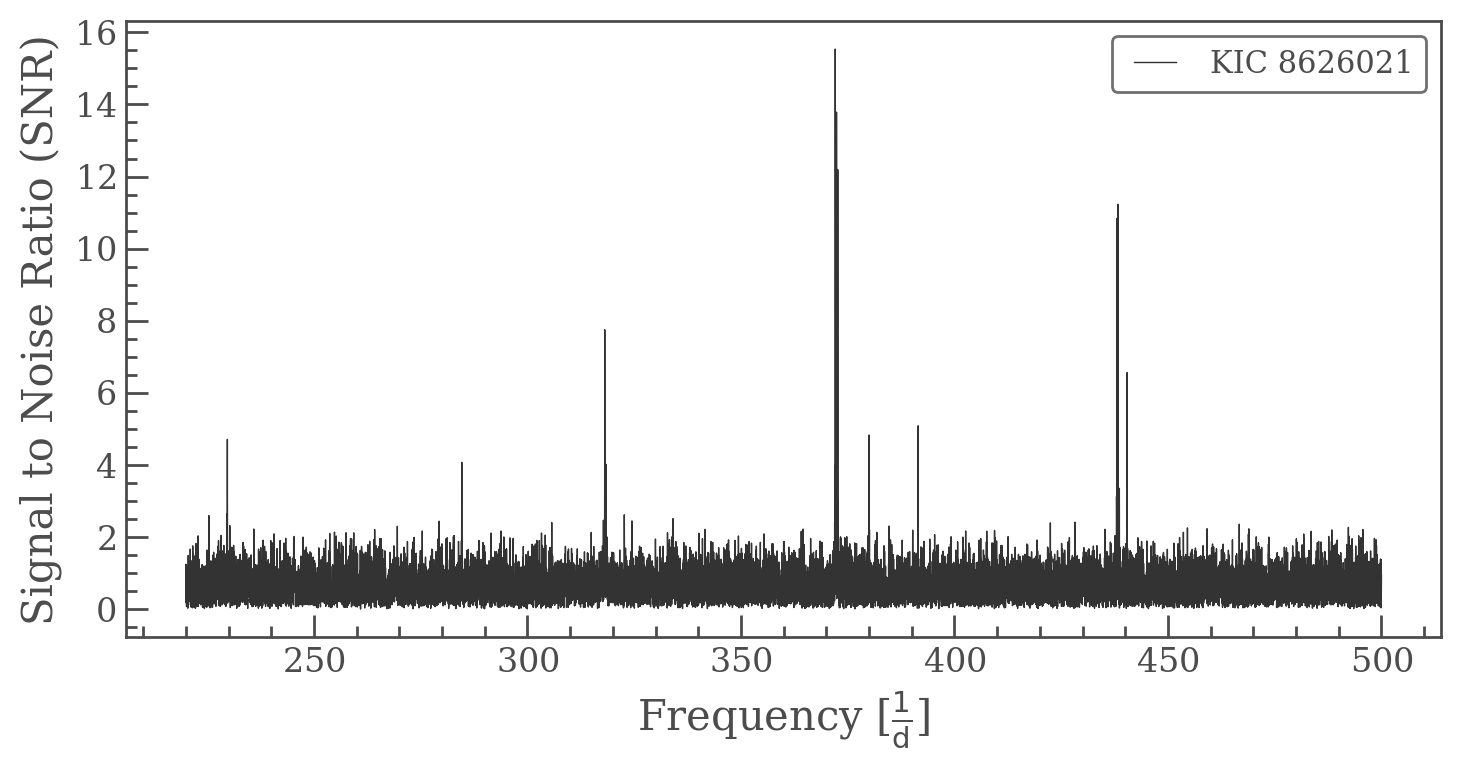

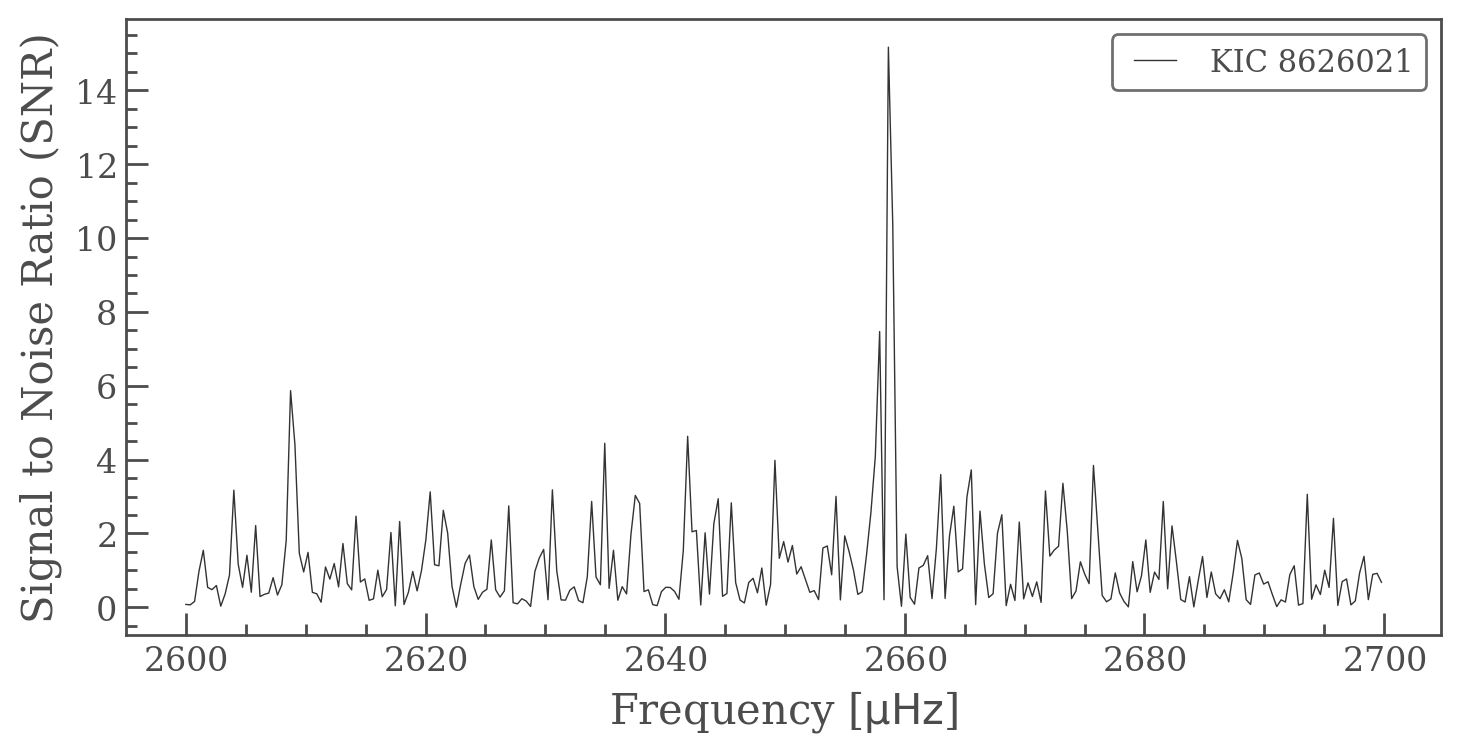

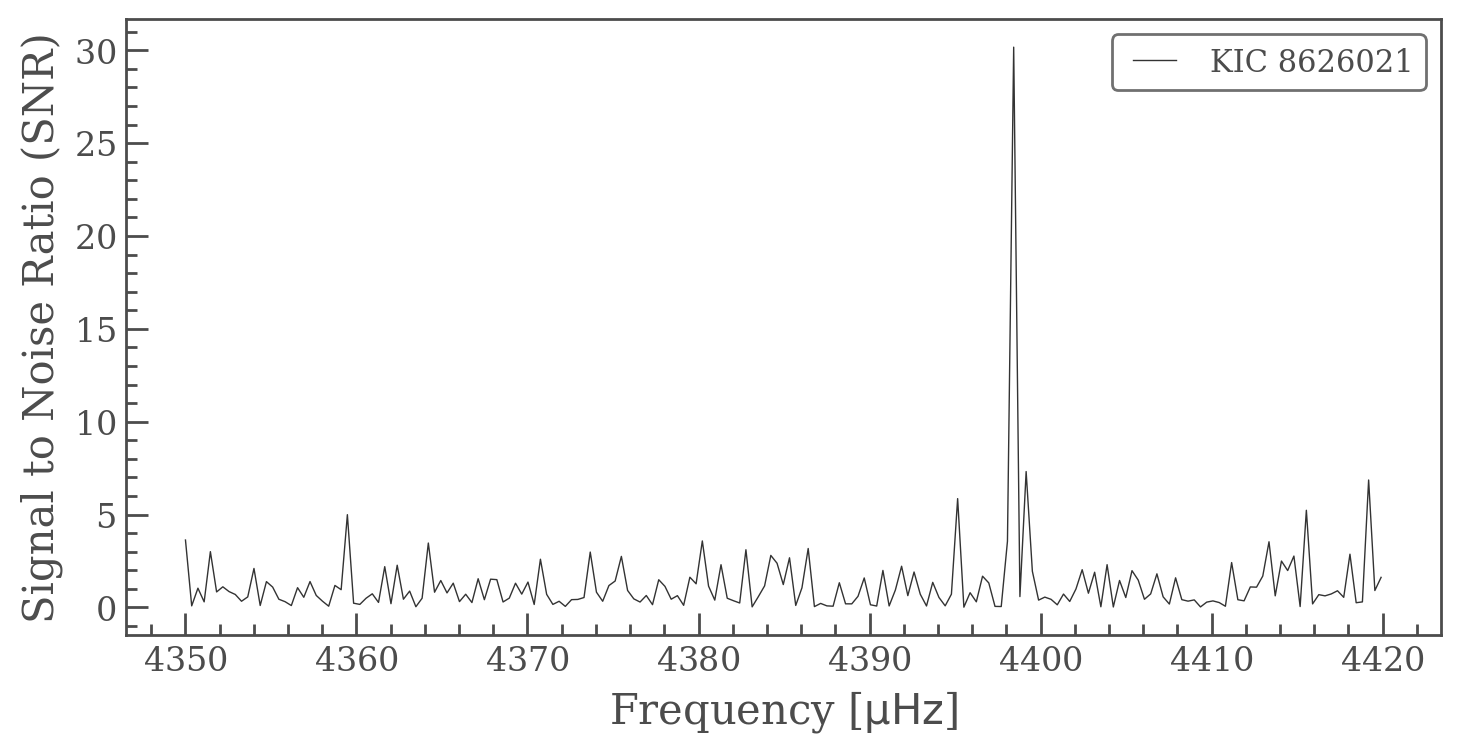

In [81]:
# zoom_pg = lc.normalize(unit = 'ppm').to_periodogram(normalization = 'psd', 
#                                                     minimum_frequency = 2500, 
#                                                     maximum_frequency = 5500).flatten()
zoom_pg = lc.normalize(unit = 'ppt').to_periodogram(minimum_frequency = 220, 
                                                    maximum_frequency = 500).flatten()
zoom_pg.plot();

zoom_pg = lc.normalize(unit = 'ppt').to_periodogram(normalization = 'psd', minimum_frequency = 2600, 
                                                    maximum_frequency = 2700).flatten()
zoom_pg.plot();

zoom_pg = lc.normalize(unit = 'ppt').to_periodogram(normalization = 'psd', minimum_frequency = 4350, 
                                                    maximum_frequency = 4420).flatten()
zoom_pg.plot();

In [45]:
seismology = zoom_pg.to_seismology()

/Users/surendrabhattarai/anaconda3/envs/juliet-env/lib/python3.11/site-packages/lightkurve/seismology/core.py:77: LightkurveWarning: Seismology received a periodogram which does not appear to have been background-corrected. Please consider calling `periodogram.flatten()` prior to extracting seismological parameters.
  warnings.warn(


In [46]:
seismology.estimate_numax()

numax: 373.36 1 / d (method: ACF2D)

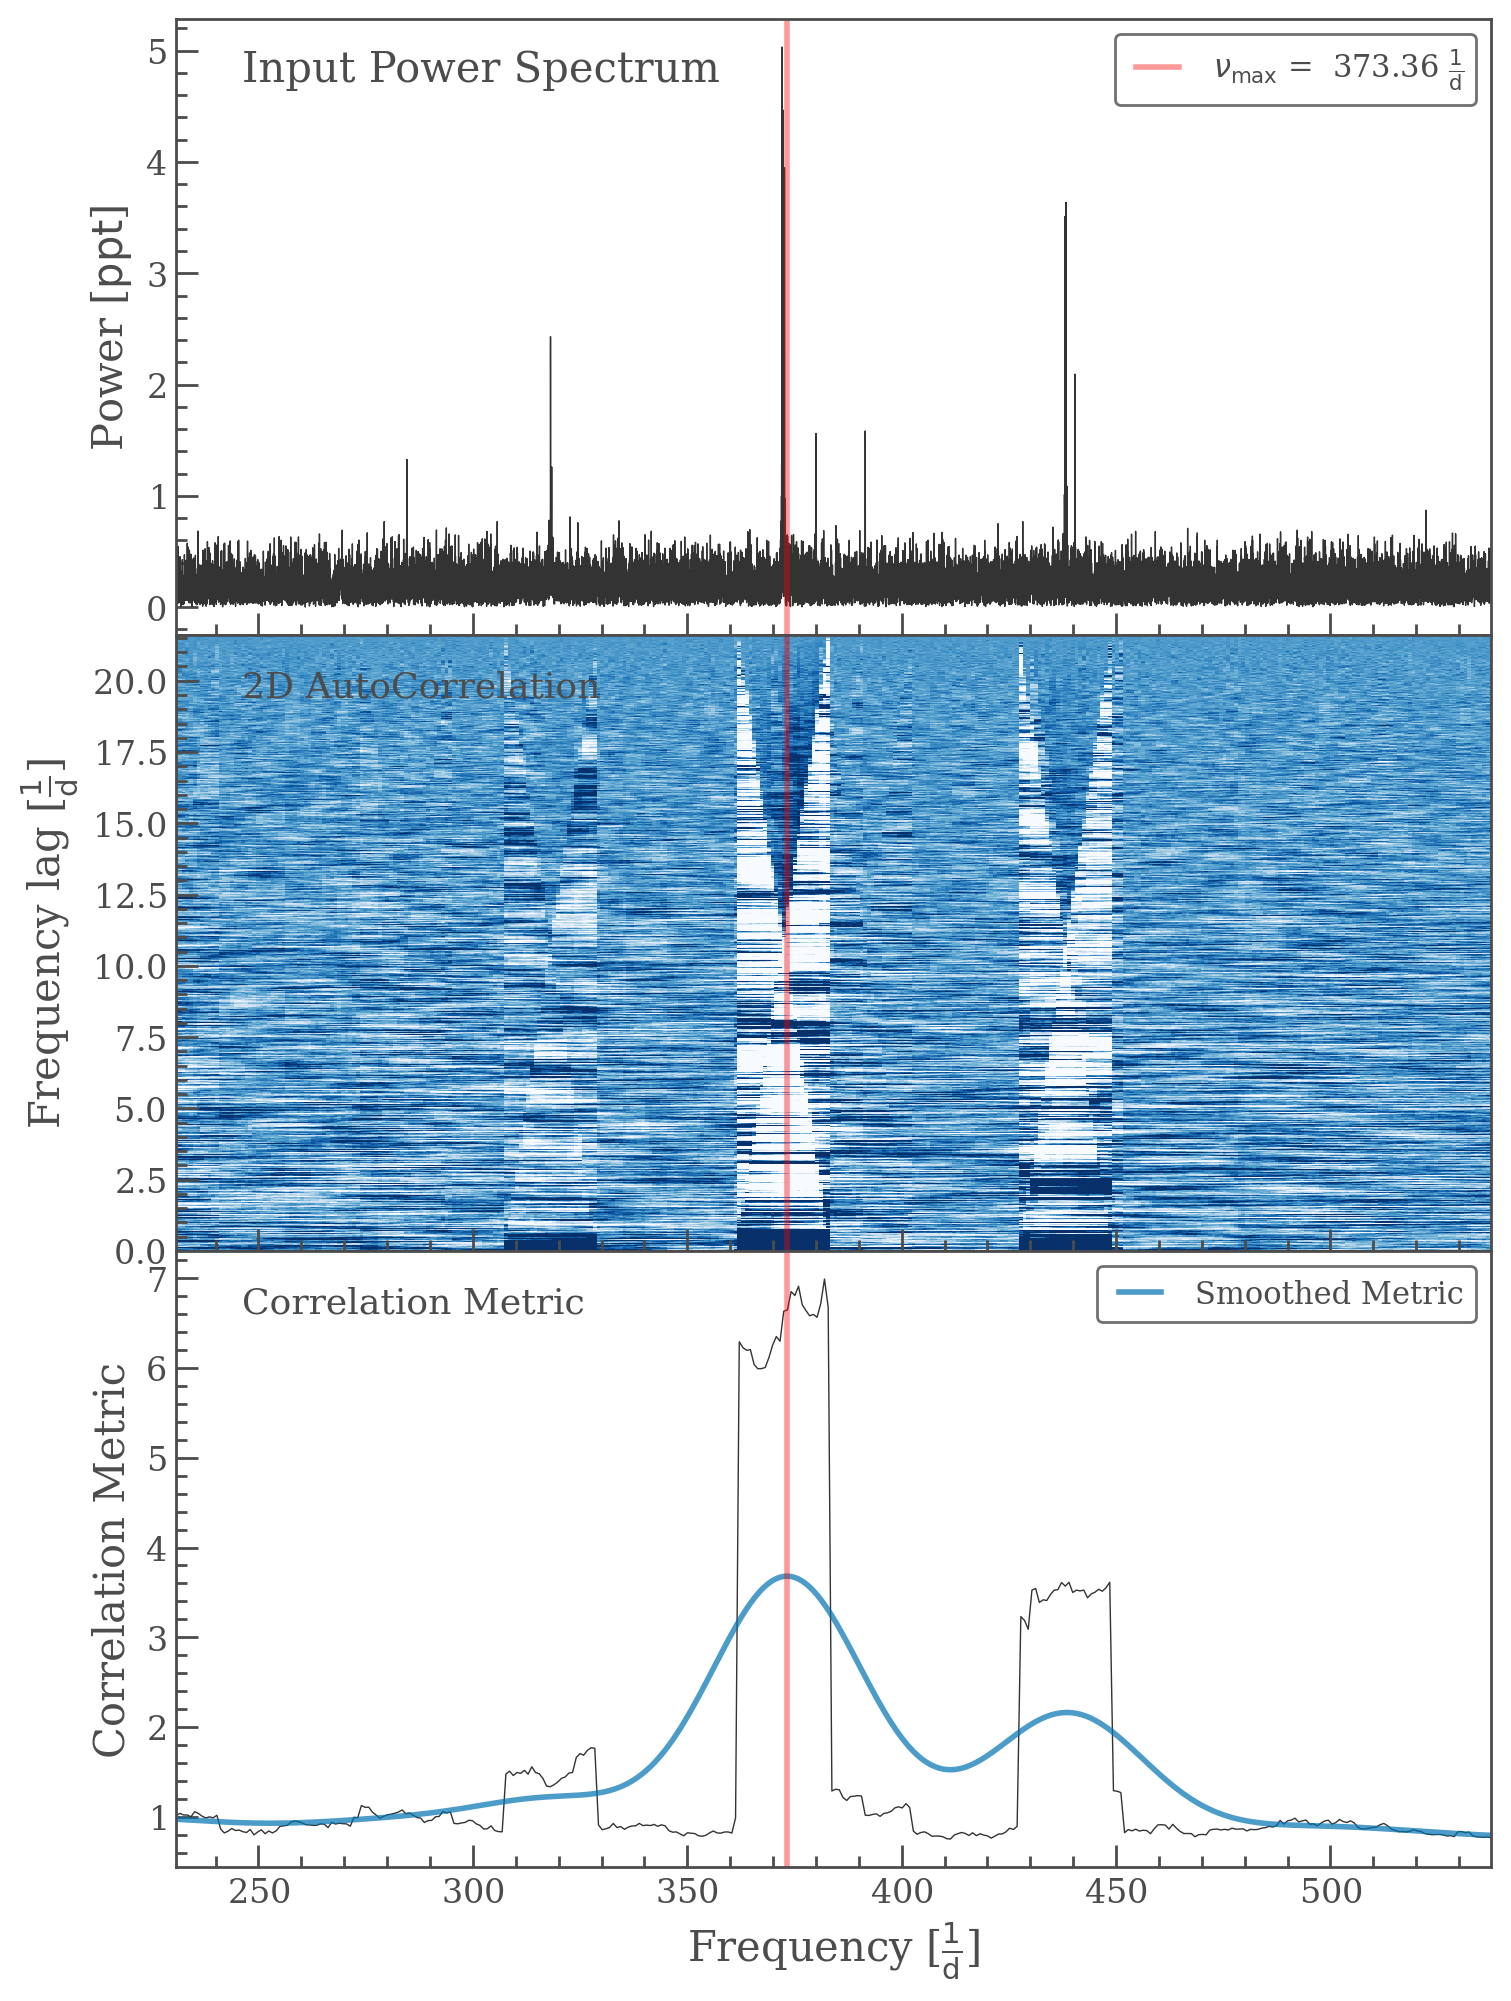

In [47]:
seismology.diagnose_numax();

In [48]:
seismology.estimate_deltanu()

deltanu: 19.42 1 / d (method: ACF2D)

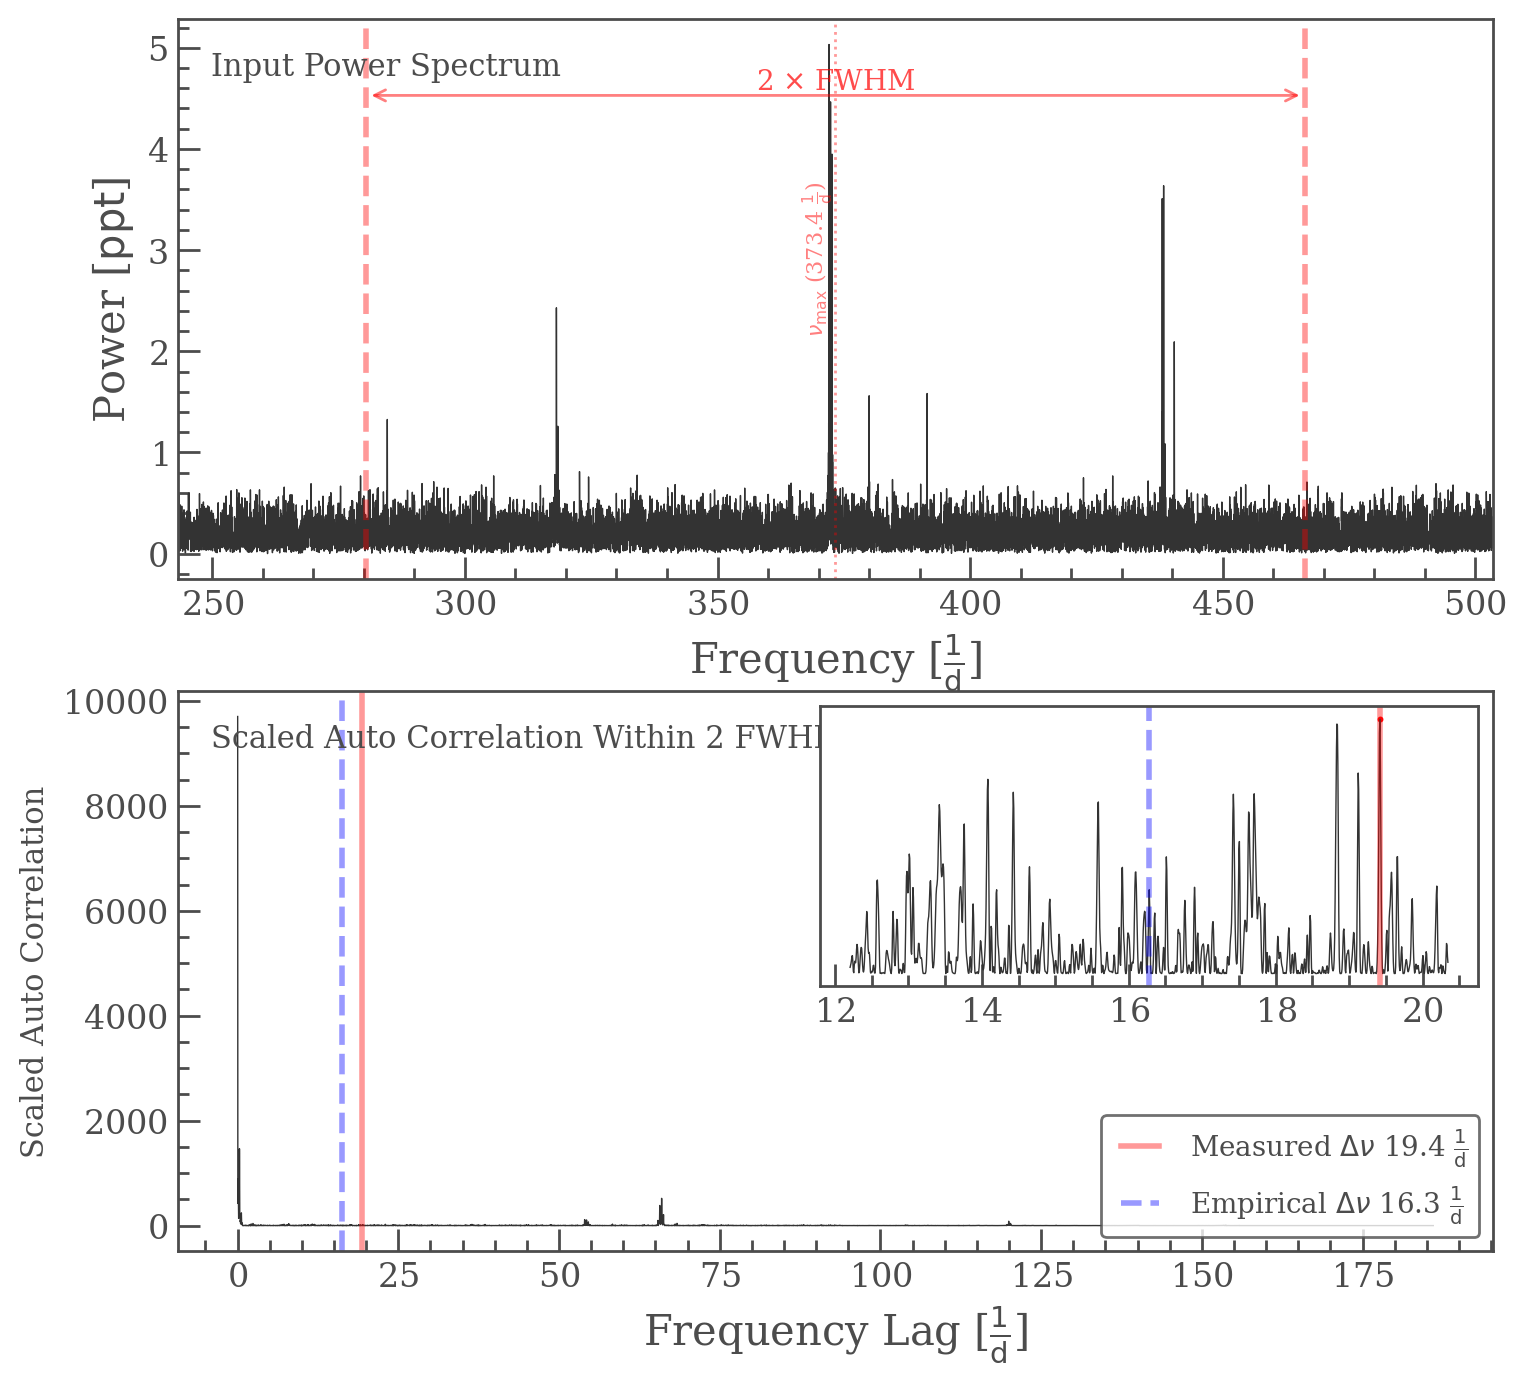

In [49]:
seismology.diagnose_deltanu();

In [26]:
# seismology.estimate_mass()

In [28]:
# seismology.estimate_radius()

In [30]:
# seismology.estimate_logg()

In [50]:
seismology

Seismology(ID: KIC 8626021) - computed values:
 * numax: 373.36 1 / d (method: ACF2D)
 * deltanu: 19.42 1 / d (method: ACF2D)

In [ ]:
# from echelle import plot_echelle #https://pypi.org/project/echelle/

In [32]:
# fig, ax = plt.subplots(figsize = (6, 5))
# plot_echelle(pg.frequency.value, pg.power.value, seismology.deltanu.value, ax = ax, cmap = 'viridis')
# ax.set_title(f'{ID}', fontsize = 15, loc = 'right')
# ax.set_xlabel(r'$\nu$ mod $\Delta\nu$ (%.2f) / $\mu Hz$'%(seismology.deltanu.value), fontsize = 15, labelpad = 15)
# ax.set_ylabel(r'Frequency $\nu$ / $\mu Hz$', fontsize = 15, labelpad = 15)

,nu0_uHz,HWHM_uHz,Height_ppt2
0,2658.524290,1.916422,3.035030e-01
1,2839.698710,1.123841,1.340111e-01
2,2993.330875,1.534262,1.043206e-01
3,3293.914695,1.638352,2.700819e-01
4,3512.522472,10.975517,5.272398e-02
5,3682.016748,1.905897,1.065713e+00
6,3867.881620,3.883080,1.174400e-01
7,4220.668483,1.146874,1.083623e-01
8,4309.258882,3.574911,4.108916e+00
9,4321.950899,0.200294,7.405957e-16


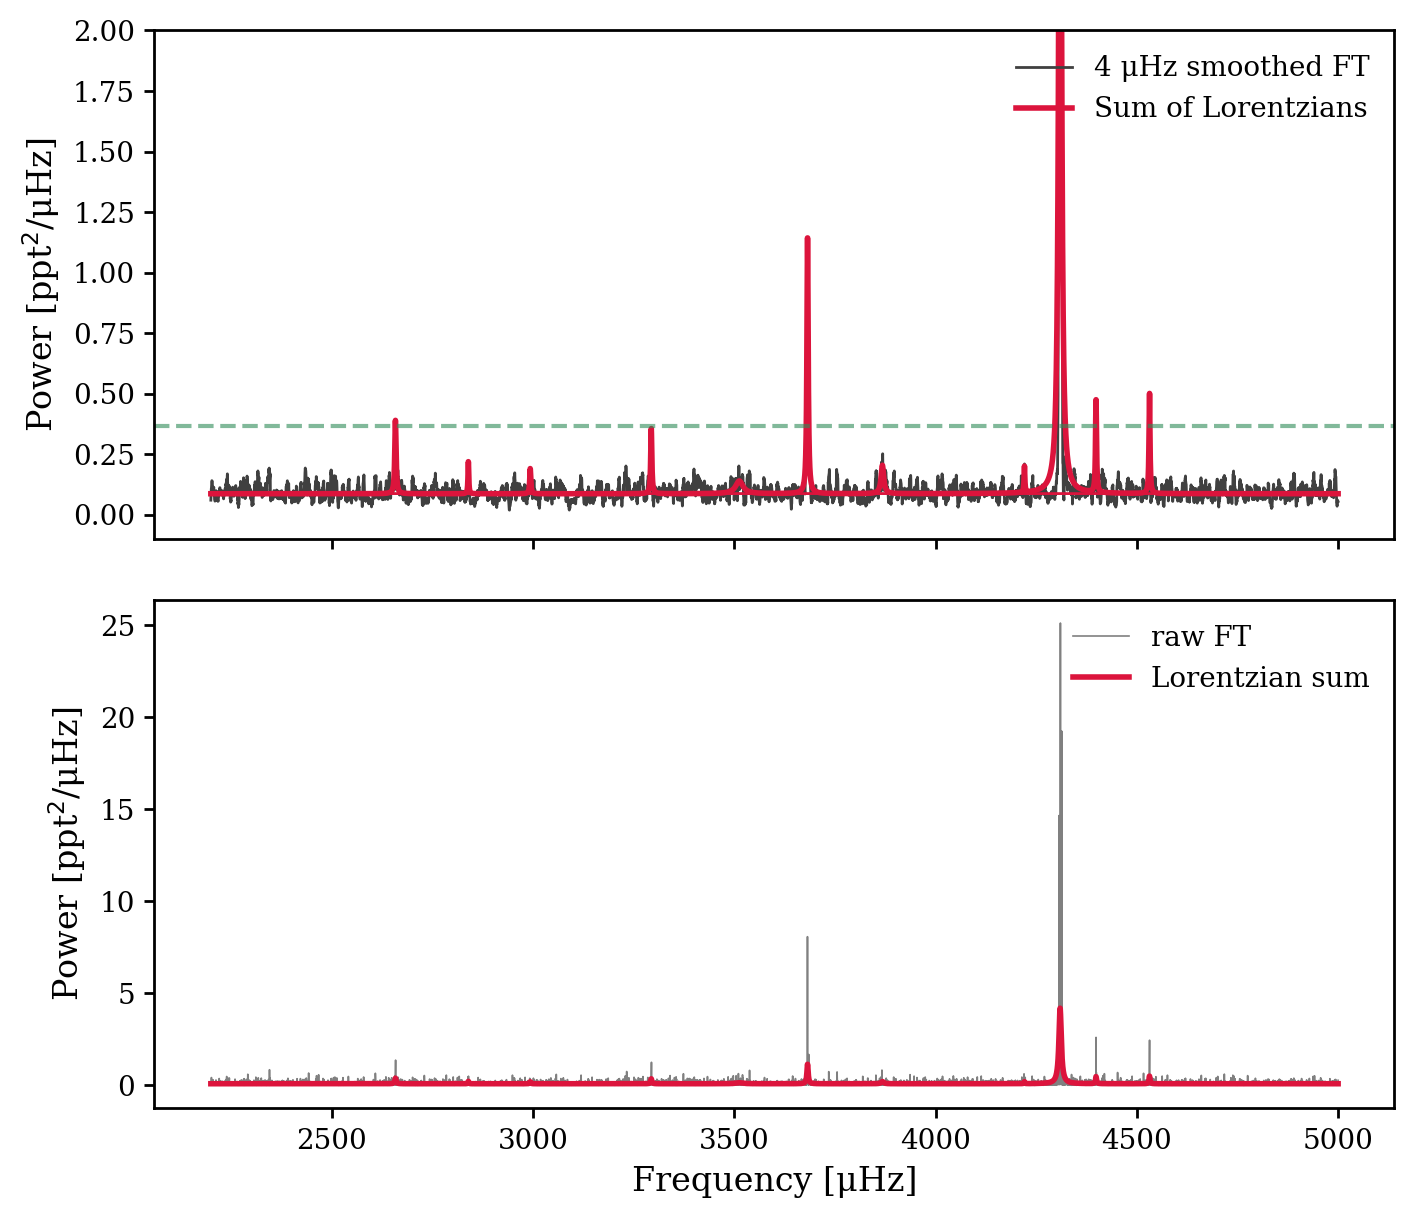

In [ ]:
f = pg.frequency.to(u.uHz).value
P = pg.power.value
band = (f >= 2200) & (f <= 5000)
f, P = f[band].astype(float), P[band].astype(float)


df = np.median(np.diff(f))


def smooth_boxcar(y, width_uHz):
    w = max(3, int(round(width_uHz/df)))
    k = np.ones(w) / w
    return np.convolve(y, k, mode="same")

P_s = smooth_boxcar(P, 4.0)

# ================== 3) Lorentzian model (on POWER) ==================
def lorentzian(fr, H, nu0, gamma):
    # single component (no baseline)
    return H / (1.0 + ((fr - nu0) / gamma) ** 2)

def lorentz_sum(fr, C, *params):
    # params = [H1,nu1,g1, H2,nu2,g2, ...]
    tot = C * np.ones_like(fr)
    for H, nu, g in np.array(params).reshape(-1, 3):
        tot += lorentzian(fr, H, nu, g)
    return tot

# ================== 4) Seed peaks robustly ==================
# use prominence, not absolute height; take top K by prominence
prom_base = np.percentile(P_s, 95)
pk, props = find_peaks(P_s,
                       prominence=0.25*prom_base,            # robust
                       distance=max(1, int(round(6.0/df))))  # ≥6 μHz apart
if pk.size == 0:  # fallback slightly looser
    pk, props = find_peaks(P_s, prominence=0.15*prom_base,
                           distance=max(1, int(round(5.0/df))))

Kmax = 12
order = np.argsort(props["prominences"])[::-1][:Kmax]
pk = pk[order]

seed_centers = f[pk]
# estimate widths from the smoothed peak shapes
w_res = peak_widths(P_s, pk, rel_height=0.5)[0] * df       # FWHM in μHz
seed_widths = np.clip(0.5 * w_res, 0.4, 6.0)               # HWHM initial
seed_heights = np.clip(P_s[pk] - np.median(P_s), 1e-4, None)

# ================== 5) Fit on the *smoothed* spectrum ==================
C0 = np.percentile(P_s, 10)
theta0 = [C0]
lo, hi = [0.0], [np.inf]
for H, nu, g in zip(seed_heights, seed_centers, seed_widths):
    theta0 += [H, nu, g]
    lo     += [0.0, nu - 4.0, 0.2]      
    hi     += [np.inf, nu + 4.0, 12.0]

popt, pcov = curve_fit(lorentz_sum, f, P_s, p0=theta0,
                       bounds=(lo, hi), maxfev=200000)


Cfit = popt[0]
pars  = np.array(popt[1:]).reshape(-1, 3)
fit_tab = pd.DataFrame(
    dict(nu0_uHz=pars[:,1], HWHM_uHz=pars[:,2], Height_ppt2=pars[:,0])
).sort_values("nu0_uHz").reset_index(drop=True)
display(fit_tab.head(20))


fig, (ax_top, ax_bot) = plt.subplots(2, 1, figsize=(8, 7), sharex=True,
                                     gridspec_kw=dict(hspace=0.12))


ax_top.plot(f, P_s, color="0.25", lw=1.0, label="4 μHz smoothed FT")
ax_top.plot(f, lorentz_sum(f, *popt), color="crimson", lw=2.0, label="Sum of Lorentzians")


for H, nu, g in pars:
    ax_top.plot(f, Cfit + lorentzian(f, H, nu, g), color="crimson", lw=0.8, alpha=0.35)


quiet = (f < 700) | (f > 1350)
sig = 4.0 * np.median(P_s[quiet])
ax_top.axhline(sig, ls="--", color="seagreen", alpha=0.6)

ax_top.set_ylabel("Power [ppt$^2$/μHz]")
# ax_top.set_xlim(600, 1400)
ax_top.set_ylim(-0.1, 2)
ax_top.legend(frameon=False, loc="upper right")


ax_bot.plot(f, P, color="0.5", lw=0.6, label="raw FT")
ax_bot.plot(f, lorentz_sum(f, *popt), color="crimson", lw=2.0, label="Lorentzian sum")
ax_bot.set_xlabel("Frequency [μHz]")
ax_bot.set_ylabel("Power [ppt$^2$/μHz]")
ax_bot.legend(frameon=False, loc="upper right")
plt.show()

In [ ]:
assert ('f' in globals()) and ('P' in globals())


Psec = 1e6 / f  # f in µHz → P in s
order = np.argsort(Psec)     
Psec  = Psec[order]
Ppow  = P[order]


Pmin, Pmax, dP = 150.0, 500.0, 0.5   
Pgrid = np.arange(Pmin, Pmax + dP/2, dP)
Ygrid = np.interp(Pgrid, Psec, Ppow) 

In [ ]:

y = Ygrid - np.median(Ygrid)
w = np.hanning(y.size)
yw = y * w


F = np.fft.rfft(yw)
nu_prime = np.fft.rfftfreq(yw.size, d=dP)     
power_PT = (F.real**2 + F.imag**2)


with np.errstate(divide='ignore'):
    spacing_s = 1.0 / nu_prime
mask = (spacing_s >= 10.0) & (spacing_s <= 100.0)  


pk, props = find_peaks(power_PT[mask], prominence=np.percentile(power_PT[mask], 90)/4)
best = pk[np.argmax(power_PT[mask][pk])] if pk.size else np.argmax(power_PT[mask])
DeltaP = float(spacing_s[mask][best])

print(f"Estimated ΔP ≈ {DeltaP:.2f} s")

Estimated ΔP ≈ 12.09 s


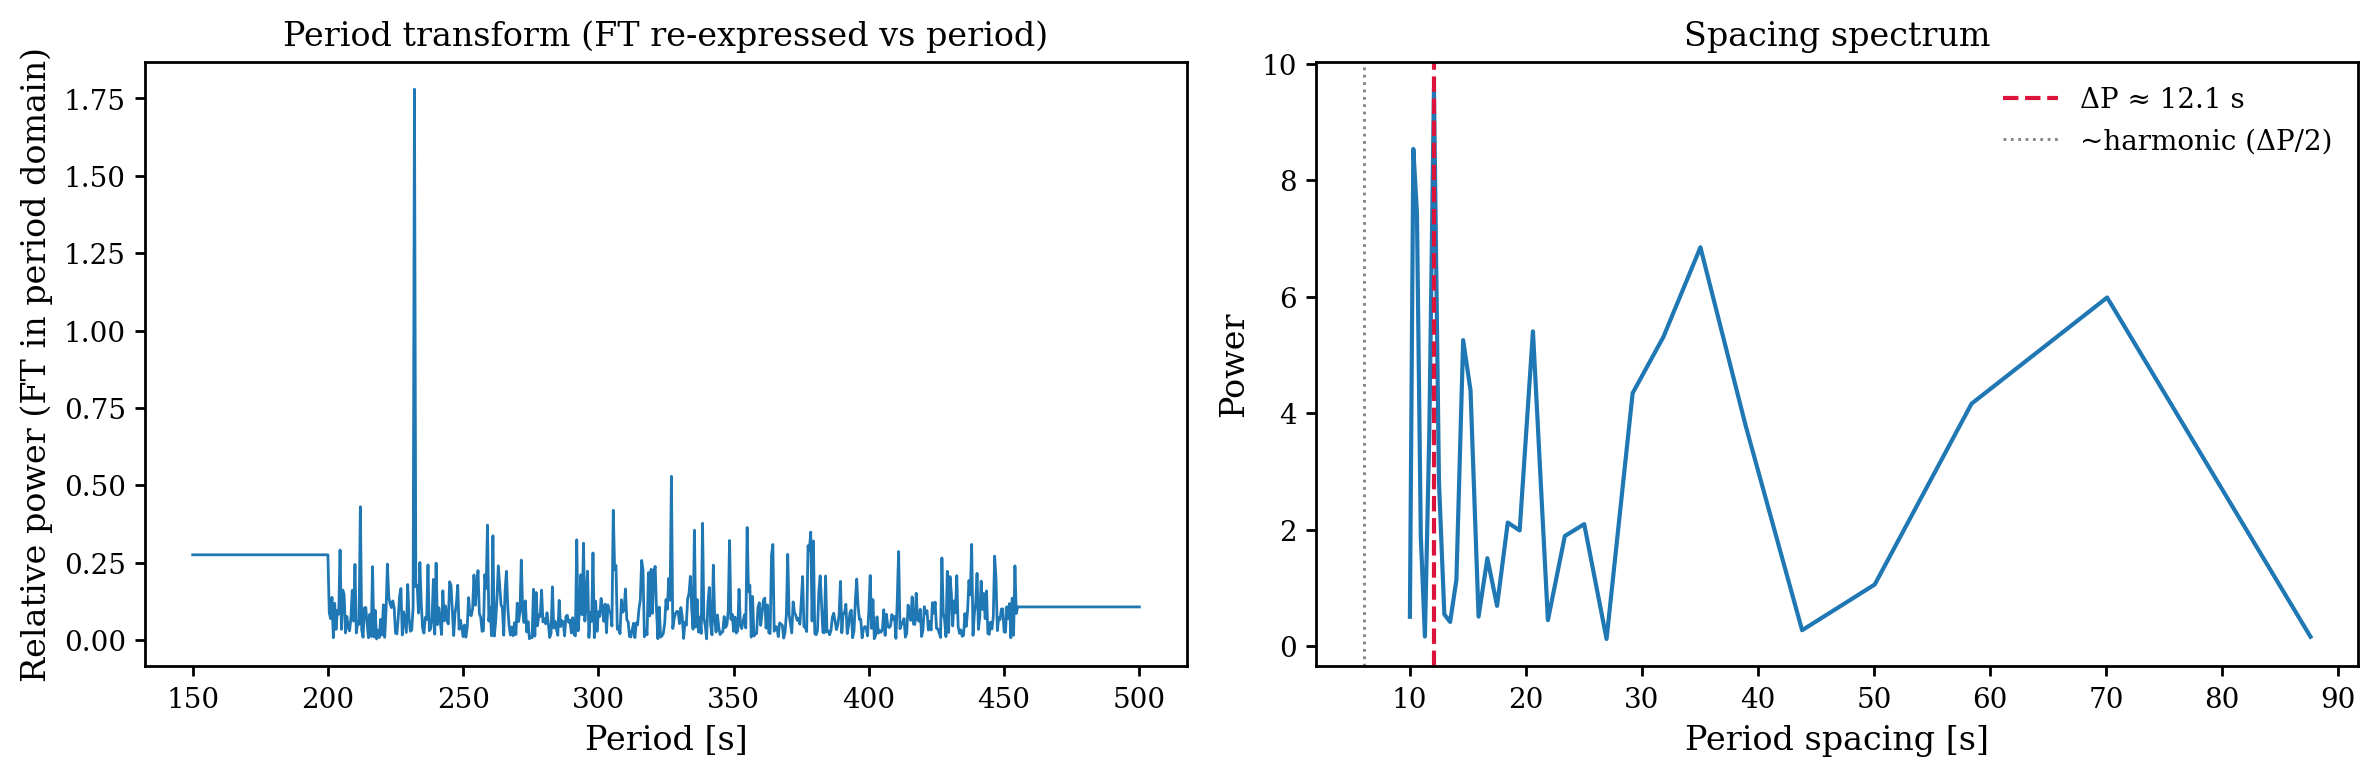

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))


ax[0].plot(Pgrid, Ygrid, color='tab:blue', lw=1)
ax[0].set_xlabel("Period [s]")
ax[0].set_ylabel("Relative power (FT in period domain)")
ax[0].set_title("Period transform (FT re-expressed vs period)")


ax[1].plot(spacing_s[mask], power_PT[mask], color='tab:blue')
ax[1].axvline(DeltaP, color='crimson', ls='--', lw=1.5, label=fr"ΔP ≈ {DeltaP:.1f} s")
ax[1].axvline(0.5*DeltaP, color='gray', ls=':', lw=1, label="~harmonic (ΔP/2)")
ax[1].set_xlabel("Period spacing [s]")
ax[1].set_ylabel("Power")
ax[1].set_title("Spacing spectrum")
ax[1].legend(frameon=False)
plt.tight_layout()
plt.show()


In [83]:
P_amp = np.sqrt(P * (df)) / 10.0

,mode,f_mode_uHz,members,f_members_uHz
0,1,3681.833666,1,3681.83
1,2,4309.977576,1,4309.98
2,3,4398.463936,1,4398.46
3,4,4531.375545,1,4531.38


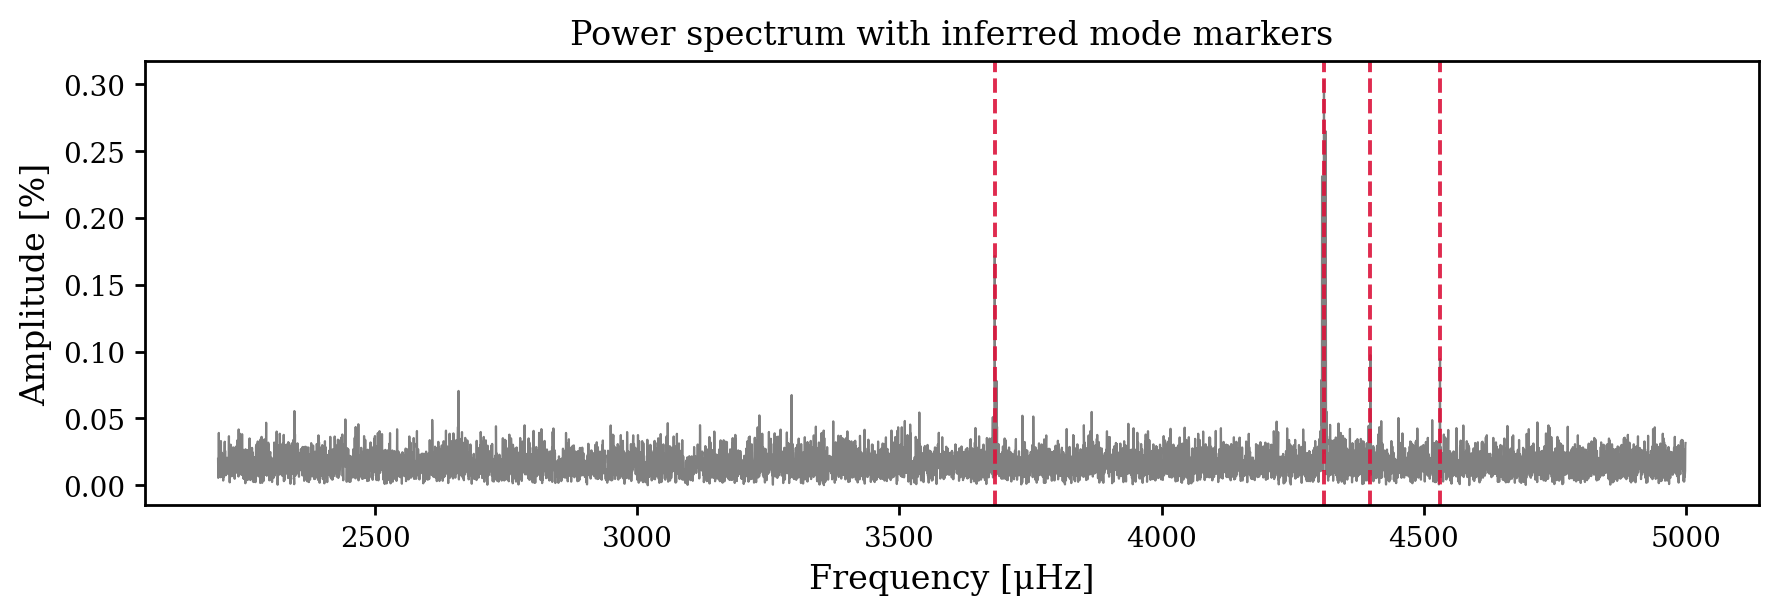

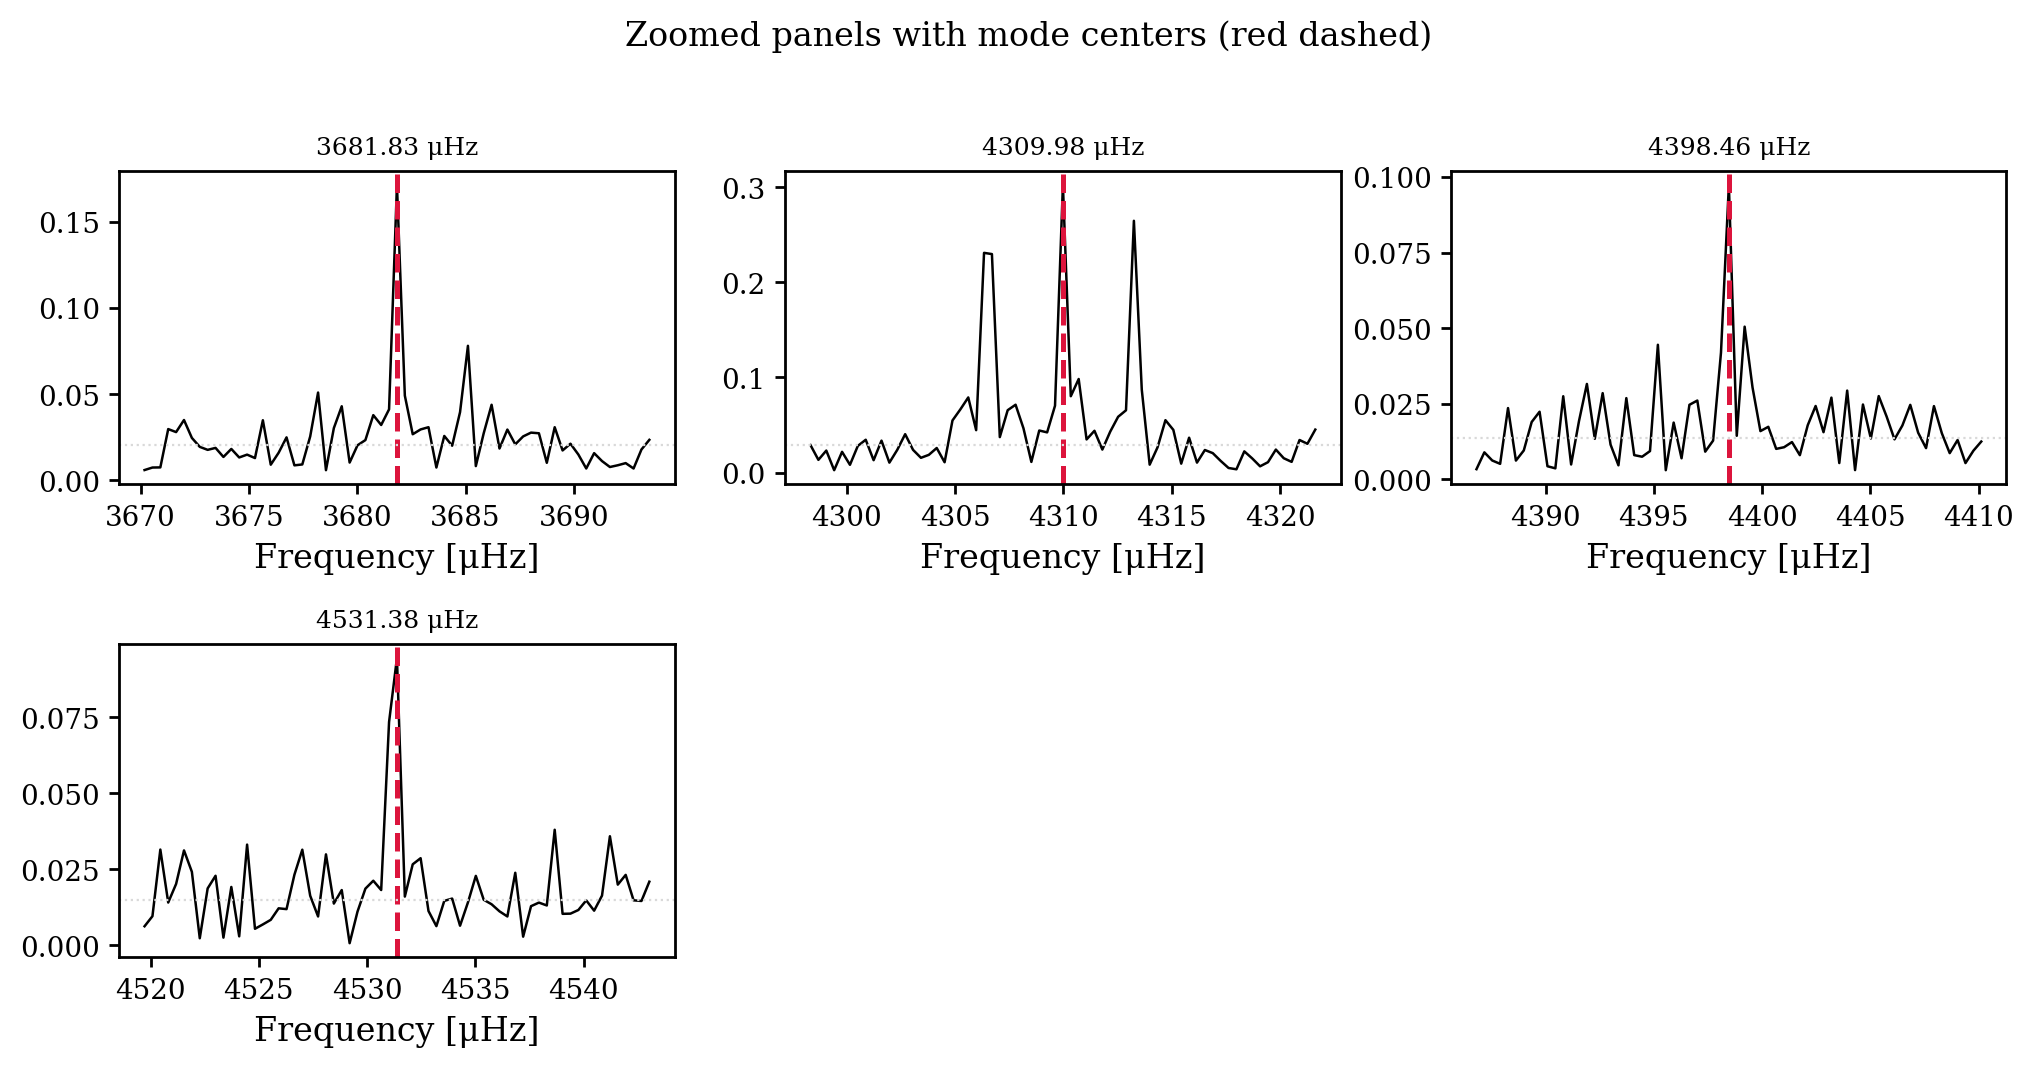

In [ ]:
MED_WIDTH_uHz      = 300.0   # running
MIN_SNR            = 5.0     # keep peaks with S/N >= this on baseline-removed spectrum
PROM_FRAC          = 0.10    # prominence threshold = PROM_FRAC * 95th-percentile(residual)
MIN_SEP_uHz        = 7.0     # cluster distance to merge rotational multiplets
MAX_MODES          = 12      # keep strongest N mode clusters
REJECT_COMBOS      = True    # drop obvious linear-combination peaks
COMBO_TOL_uHz      = 1.0     # tolerance for combo checks
PANEL_HALFWIDTH_uHz= 12.0    # half-width of each zoom panel
NCOLS              = 3       # panels per row

PRIOR_FREQS_uHz    = []      


k_med = max(3, int(round(MED_WIDTH_uHz/df)) | 1)  
baseline = median_filter(P, size=k_med, mode="nearest")
R = np.clip(P - baseline, 0, None)              
mad = 1.4826 * np.median(np.abs(R - np.median(R)))
if not np.isfinite(mad) or mad <= 0:
    mad = np.std(R) if np.std(R) > 0 else 1e-12
snr = R / mad

# Peak seeding on residual
prom_thr = PROM_FRAC * np.percentile(R, 95.0)
pk, props = find_peaks(R,
                       distance=max(1, int(round(MIN_SEP_uHz/df))),
                       prominence=prom_thr)
if pk.size == 0:
    raise RuntimeError("No peaks found — relax PROM_FRAC or MIN_SNR.")

keep = snr[pk] >= MIN_SNR   # keeping high-S/N peaks only
pk = pk[keep]
if pk.size == 0:
    raise RuntimeError("No peaks pass MIN_SNR — lower MIN_SNR or widen band.")

order = np.argsort(R[pk])[::-1]
pk = pk[order][:max(MAX_MODES, 1)]
f_pk = f[pk]  # seed frequencies

# drop obvious linear combinations 
if REJECT_COMBOS and f_pk.size >= 3:
    mask = np.ones_like(f_pk, dtype=bool)

    for i in range(f_pk.size):
        if not mask[i]:
            continue
        fi = f_pk[i]
        combos = []
        for j in range(i):
            for k in range(j):
                fj, fk = f_pk[j], f_pk[k]
                combos.extend([abs(fj+fk), abs(fj-fk)])
        if len(combos):
            combos = np.asarray(combos)
            if np.min(np.abs(combos - fi)) < COMBO_TOL_uHz:
                mask[i] = False
    f_pk = f_pk[mask]

    pk = np.array([np.argmin(np.abs(f - val)) for val in f_pk])


seeds = np.sort(pk)
clusters = []
if seeds.size:
    cur = [seeds[0]]
    for idx in seeds[1:]:
        if (f[idx] - f[cur[-1]]) <= MIN_SEP_uHz:
            cur.append(idx)
        else:
            clusters.append(cur); cur = [idx]
    clusters.append(cur)

mode_freqs = []
for cl in clusters:
    w = np.maximum(R[cl], 1e-12)
    mode_freqs.append(np.sum(f[cl]*w)/np.sum(w))
mode_freqs = np.sort(np.array(mode_freqs))


mrows = []
for i, cl in enumerate(clusters, 1):
    mrows.append({
        "mode": i,
        "f_mode_uHz": mode_freqs[i-1],
        "members": len(cl),
        "f_members_uHz": ", ".join([f"{f[j]:.2f}" for j in cl])
    })
modes_df = pd.DataFrame(mrows)
display(modes_df)


fig, ax = plt.subplots(1, 1, figsize=(9, 3.2))
ax.plot(f, P_amp, color="0.5", lw=0.8)
for fm in mode_freqs:
    ax.axvline(fm, color="crimson", ls="--", lw=1.4, alpha=0.9)
for fp in PRIOR_FREQS_uHz:
    ax.axvline(fp, color="royalblue", ls="-.", lw=1.2, alpha=0.8)
ax.set_xlabel("Frequency [μHz]"); 
# ax.set_ylabel("Power [ppt$^2$/μHz]")
ax.set_ylabel("Amplitude [%]")
ax.set_title("Power spectrum with inferred mode markers")
plt.tight_layout()
plt.show()

n = len(mode_freqs)
if n == 0:
    print("No modes to plot.")
else:
    ncols = NCOLS
    nrows = int(np.ceil(n / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(3.4*ncols, 2.6*nrows), squeeze=False)
    axes = axes.ravel()

    for i, fm in enumerate(mode_freqs):
        axp = axes[i]
        m = (f >= fm - PANEL_HALFWIDTH_uHz) & (f <= fm + PANEL_HALFWIDTH_uHz)
        axp.plot(f[m], P_amp[m], color="k", lw=0.9)
        axp.axvline(fm, color="crimson", ls="--", lw=1.8)  # observed mode (red)
        for fp in PRIOR_FREQS_uHz:
            if (fm - PANEL_HALFWIDTH_uHz) <= fp <= (fm + PANEL_HALFWIDTH_uHz):
                axp.axvline(fp, color="royalblue", ls="-.", lw=1.5, alpha=0.9)  # optional theory (blue)
        axp.set_title(f"{fm:.2f} μHz", fontsize=9)
        axp.set_xlabel("Frequency [μHz]"); 
        # axp.set_ylabel("Power")
        ax.set_ylabel("Amplitude [%]")
        axp.axhline(np.median(P_amp[m]), color="0.85", lw=0.8, ls=":")

    for j in range(i+1, len(axes)):
        axes[j].axis("off")

    fig.suptitle("Zoomed panels with mode centers (red dashed)", y=1.02, fontsize=12)
    plt.tight_layout()
    plt.show()

Mode identification

In [ ]:
f = pg.frequency.to(u.uHz).value
P = pg.power.value


band = (f >= 2200) & (f <= 5000)
f, P = f[band].astype(float), P[band].astype(float)
T_days = float(lc.time.jd.max() - lc.time.jd.min())

#  best ΔΠ_1 (seconds) else 41.1 s
dP1_s = float(globals().get("dP1_s", globals().get("dP_fund", 41.1)))


if "centers_uHz" not in globals():
    df = np.median(np.diff(f))
    def smooth_box(y, width_uHz):
        w = max(3, int(round(width_uHz/df)))
        k = np.ones(w)/w
        return np.convolve(y, k, mode="same")
    P_s = smooth_box(P, 4.0)
    prom_base = np.percentile(P_s, 95)
    pk, props = find_peaks(P_s, prominence=0.25*prom_base, distance=max(1, int(round(6.0/df))))
    if pk.size == 0:
        pk, props = find_peaks(P_s, prominence=0.15*prom_base, distance=max(1, int(round(5.0/df))))
    # keep top 12 by prominence
    order = np.argsort(props["prominences"])[::-1][:12]
    centers_uHz = f[pk[order]]

print(f"T_days = {T_days:.3f} d,  ΔΠ1 = {dP1_s:.2f} s,  N(centers) = {len(np.atleast_1d(centers_uHz))}")


T_days = 31.794 d,  ΔΠ1 = 41.10 s,  N(centers) = 12


In [ ]:

rayleigh_uHz = 1e6 / (T_days * 86400.0)
dP2_s = dP1_s / np.sqrt(3.0)  # asymptotic relation wooho

def refine_phi(periods_s, dP_s, pmin, pmax, weights=None):

    P = np.asarray(periods_s, float)
    m = (P >= pmin) & (P <= pmax)
    P = P[m]
    if P.size == 0:
        return pmin
    W = np.ones_like(P) if weights is None else np.asarray(weights, float)[m]
    phis = np.linspace(pmin, pmin + dP_s, 2001, endpoint=False)

    scores = []
    for phi in phis:
        k = np.rint((P - phi)/dP_s)
        dist = np.abs(P - (phi + k*dP_s))
        scores.append(np.average(dist, weights=W))
    return float(phis[np.argmin(scores)])

def nearest_comb_residual(P_s, dP_s, phi_s):
    k = np.rint((P_s - phi_s)/dP_s)
    P_model = phi_s + k*dP_s
    return (P_s - P_model), k.astype(int), P_model


if 'centers_uHz' in globals():
    nu_candidates = np.asarray(centers_uHz, float)
else:

    df_uHz = np.median(np.diff(f))
    def smooth_box(y, w_uHz):
        w = max(3, int(round(w_uHz/df_uHz)))
        k = np.ones(w)/w
        return np.convolve(y, k, mode='same')
    P_s = smooth_box(P, 4.0)
    prom_base = np.percentile(P_s, 95)
    pk, props = find_peaks(P_s, prominence=0.25*prom_base, distance=max(1,int(round(6.0/df_uHz))))
    if pk.size == 0:
        pk, props = find_peaks(P_s, prominence=0.15*prom_base, distance=max(1,int(round(5.0/df_uHz))))
    order = np.argsort(props["prominences"])[::-1][:20]
    nu_candidates = f[pk[order]]


periods_s = 1e6/nu_candidates
pmin, pmax = 780.0, 1600.0



def local_power_weight(nu0, span=5.0):
    m = (f >= nu0-span) & (f <= nu0+span)
    return float(P[m].max()) if np.any(m) else 1.0

weights = np.array([local_power_weight(nu) for nu in nu_candidates])

phi1 = refine_phi(periods_s, dP1_s, pmin, pmax, weights=weights)
phi2 = refine_phi(periods_s, dP2_s, pmin, pmax, weights=weights)


rows = []
tolP_s = 0.5*dP1_s   
for nu in nu_candidates:
    P0 = 1e6/nu
    r1, k1, P1_mod = nearest_comb_residual(P0, dP1_s, phi1)
    r2, k2, P2_mod = nearest_comb_residual(P0, dP2_s, phi2)

    if abs(r1) < abs(r2):
        ell, k_used, resid_s, P_model = 1, int(k1), float(r1), float(P1_mod)
    else:
        ell, k_used, resid_s, P_model = 2, int(k2), float(r2), float(P2_mod)

    assigned = (abs(resid_s) <= tolP_s)
    rows.append({
        "nu_uHz": float(nu),
        "P_s": float(P0),
        "ell": ell if assigned else None,
        "k": k_used if assigned else None,
        "resid_s": resid_s,
        "P_model_s": P_model
    })

assign = pd.DataFrame(rows).sort_values("nu_uHz").reset_index(drop=True)

######################################################################### trying to detect rotational splitting around each base component 

def find_multiplet(nu0, neighborhood=12.0, min_peaks=2):
    nearmask = (f >= nu0-neighborhood) & (f <= nu0+neighborhood)
    ff = f[nearmask]; PP = P[nearmask]
    # finding local peaks
    pk, props = find_peaks(PP, prominence=np.percentile(PP,95)*0.15, distance=max(1,int(round(2.0/np.median(np.diff(ff))))))
    if pk.size < min_peaks:
        return None
    nu_peaks = ff[pk]
    nu_peaks = np.sort(nu_peaks)
    
    if nu_peaks.size >= 3:
        dnu = np.median(np.diff(nu_peaks))
        return {"nu_peaks":nu_peaks, "dnu_uHz":float(dnu)}  # estimate a common spacing by median nearest-neighbor spacing
    return None

mult_rows = []
for i, r in assign.iterrows():
    info = find_multiplet(r["nu_uHz"])
    mult_rows.append(info if info is not None else {})
assign["dnu_uHz"] = [m.get("dnu_uHz", np.nan) for m in mult_rows]

# infering m given dnu and ℓ (very rough): label central as m≈0 and neighbors by ±1, ±2 if spacing ~dnu
def label_members(nu0, nu_list, dnu, ell):
    # simple integer rounding of (nu-nu0)/dnu
    m_vals = []
    for nu in nu_list:
        m = int(np.rint((nu - nu0)/dnu))
        if abs(m) <= ell:  # only valid range
            m_vals.append((nu, m))
    return m_vals

m_labels = []
for i, r in assign.iterrows():
    if np.isfinite(r["dnu_uHz"]) and (r["ell"] in (1,2)):
        mm = find_multiplet(r["nu_uHz"])
        if mm:
            labeled = label_members(r["nu_uHz"], mm["nu_peaks"], mm["dnu_uHz"], r["ell"])
            m_labels.append(labeled)
        else:
            m_labels.append([])
    else:
        m_labels.append([])

assign["m_members"] = m_labels

# 7) final tidy view
assign_display = assign.copy()
assign_display["mode_label"] = assign_display.apply(
    lambda r: (f"ℓ={r['ell']}, k={r['k']}" if pd.notnull(r['ell']) else "—"), axis=1
)
assign_display = assign_display[["nu_uHz","P_s","mode_label","resid_s","dnu_uHz","m_members"]]
display(assign_display)

,nu_uHz,P_s,mode_label,resid_s,dnu_uHz,m_members
0,2658.232199,376.189860,"ℓ=2, k=-17",-0.415506,4.005555,"[(2649.128663868449, -2), (2654.2266434277835,..."
1,2839.938756,352.120269,"ℓ=2, k=-18",-0.756001,2.184848,"[(2835.5690591812527, -2), (2837.3897661667293..."
2,2993.606426,334.045248,"ℓ=2, k=-19",4.898073,3.277273,"[(2985.5953147845244, -2), (2987.780163167096,..."
3,3294.023078,303.580144,"ℓ=2, k=-20",-1.837935,2.548990,"[(3287.8326743736393, -2), (3291.4740883445925..."
4,3511.415492,284.785438,"ℓ=1, k=-12",-2.014562,2.548990,"[(3510.3230679988797, 0), (3512.8720577785466,..."
5,3683.290232,271.496390,"ℓ=2, k=-21",-10.192593,3.277273,"[(3675.6432622801544, -2), (3678.192252059822,..."
6,3868.638203,258.488891,"ℓ=2, k=-22",0.529005,2.184848,"[(3864.26850597553, -2), (3866.8174957551973, ..."
7,4220.762934,236.923991,"ℓ=2, k=-23",2.693201,2.913131,"[(4214.208388584132, -2), (4217.849802555085, ..."
8,4308.156869,232.117824,"ℓ=2, k=-23",-2.112966,3.459343,"[(4306.336162049248, -1), (4309.977576020201, ..."
9,4322.722525,231.335690,"ℓ=2, k=-23",-2.895100,2.548990,"[(4321.630100727251, 0), (4323.814949109823, 0..."


Full spectrum with mode markers + multiplets

/var/folders/b_/91swq2f51r35gl42858jqwd00000gn/T/ipykernel_30741/3103323979.py:38: UserWarning: Glyph 8467 (\N{SCRIPT SMALL L}) missing from font(s) DejaVu Serif.
  plt.tight_layout()
/Users/surendrabhattarai/anaconda3/envs/juliet-env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8467 (\N{SCRIPT SMALL L}) missing from font(s) DejaVu Serif.
  fig.canvas.print_figure(bytes_io, **kw)


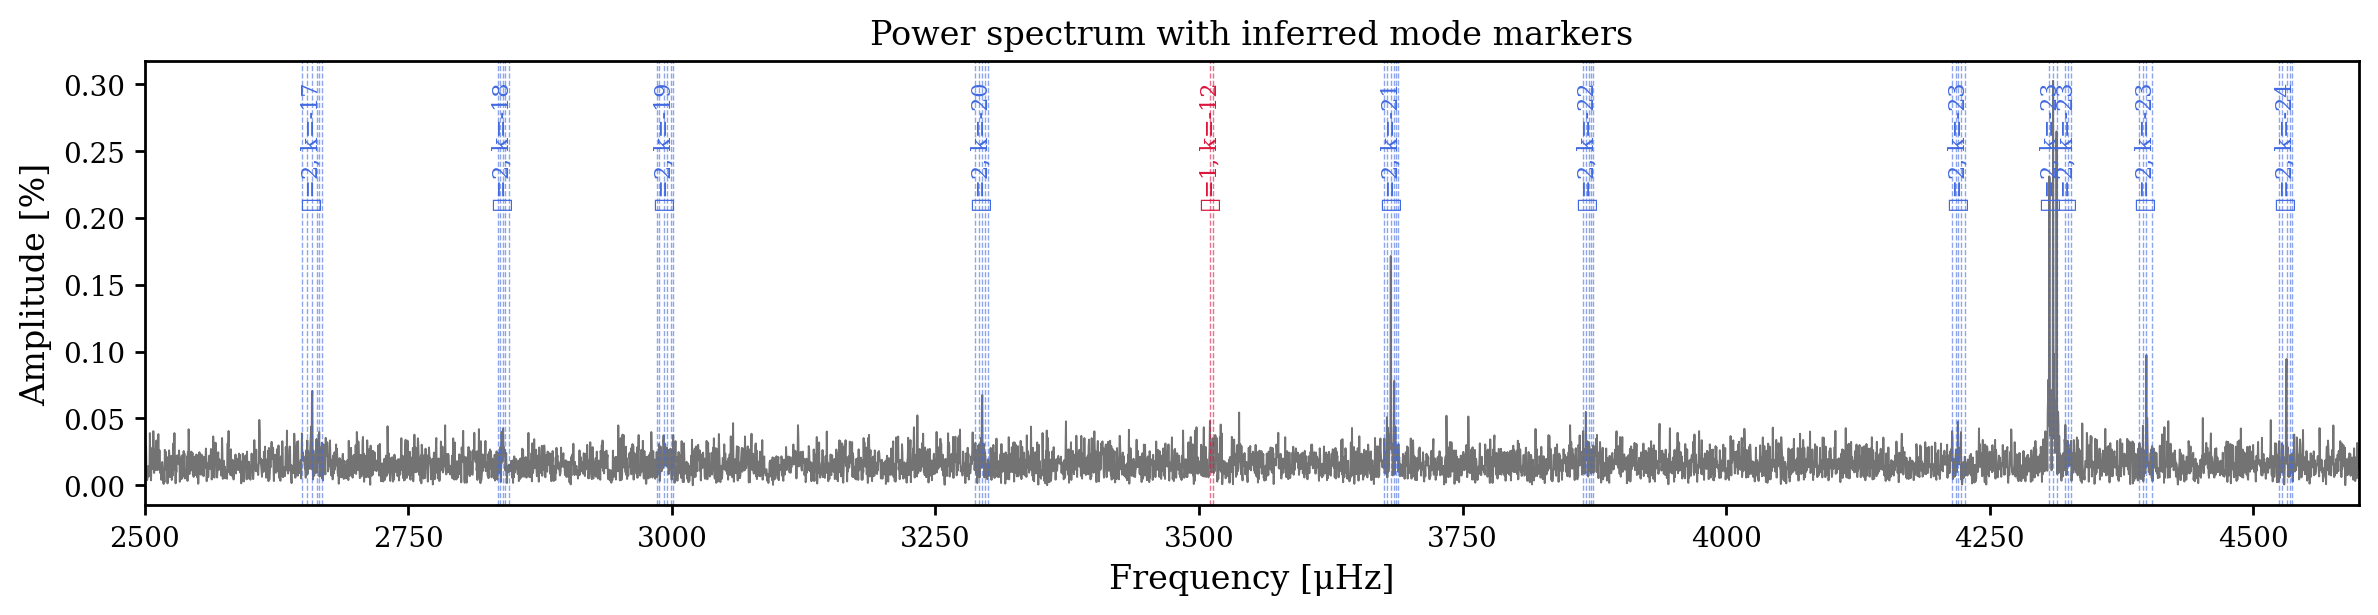

In [108]:
modes = assign_display[['nu_uHz','P_s','mode_label','resid_s','dnu_uHz','m_members']].copy()

# --- helpers from your table ---
def ell_from_label(s: str) -> int:
    # expects strings like "ℓ=2, k=-23"
    return int(s.split(',')[0].split('=')[1])

colors = {1: "crimson", 2: "royalblue"}

modes_plot = modes.sort_values("nu_uHz").reset_index(drop=True)

fig, ax = plt.subplots(figsize=(12, 3.2))
ax.plot(f, P_amp, color="0.45", lw=0.7)
ax.set_xlim(f.min(), f.max())
ax.set_xlabel("Frequency [μHz]")
# ax.set_ylabel("Power [ppt$^2$/μHz]")
ax.set_ylabel("Amplitude [%]")
ax.set_title("Power spectrum with inferred mode markers")
ax.set_xlim(2500,4600)

for _, row in modes_plot.iterrows():
    ell = ell_from_label(row["mode_label"])
    c   = colors.get(ell, "tab:gray")

    # mode center
    # ax.axvline(row["nu_uHz"], color=c, ls="--", lw=1.6, alpha=0.9, zorder=3)

    # annotate ℓ,k above the line
    ax.text(row["nu_uHz"], ax.get_ylim()[1]*0.95, row["mode_label"],
            color=c, rotation=90, ha="center", va="top", fontsize=8)

    # optional: draw rotational multiplet members (thin dotted lines)
    mm = row.get("m_members", None)
    if isinstance(mm, (list, tuple)):
        for nu_m, mcomp in mm:
            ax.axvline(nu_m, color=c, ls="--", lw=0.5, alpha=0.6)

plt.tight_layout()
plt.show()


(Optional) Period échelle of your identified modes, colored by ℓ

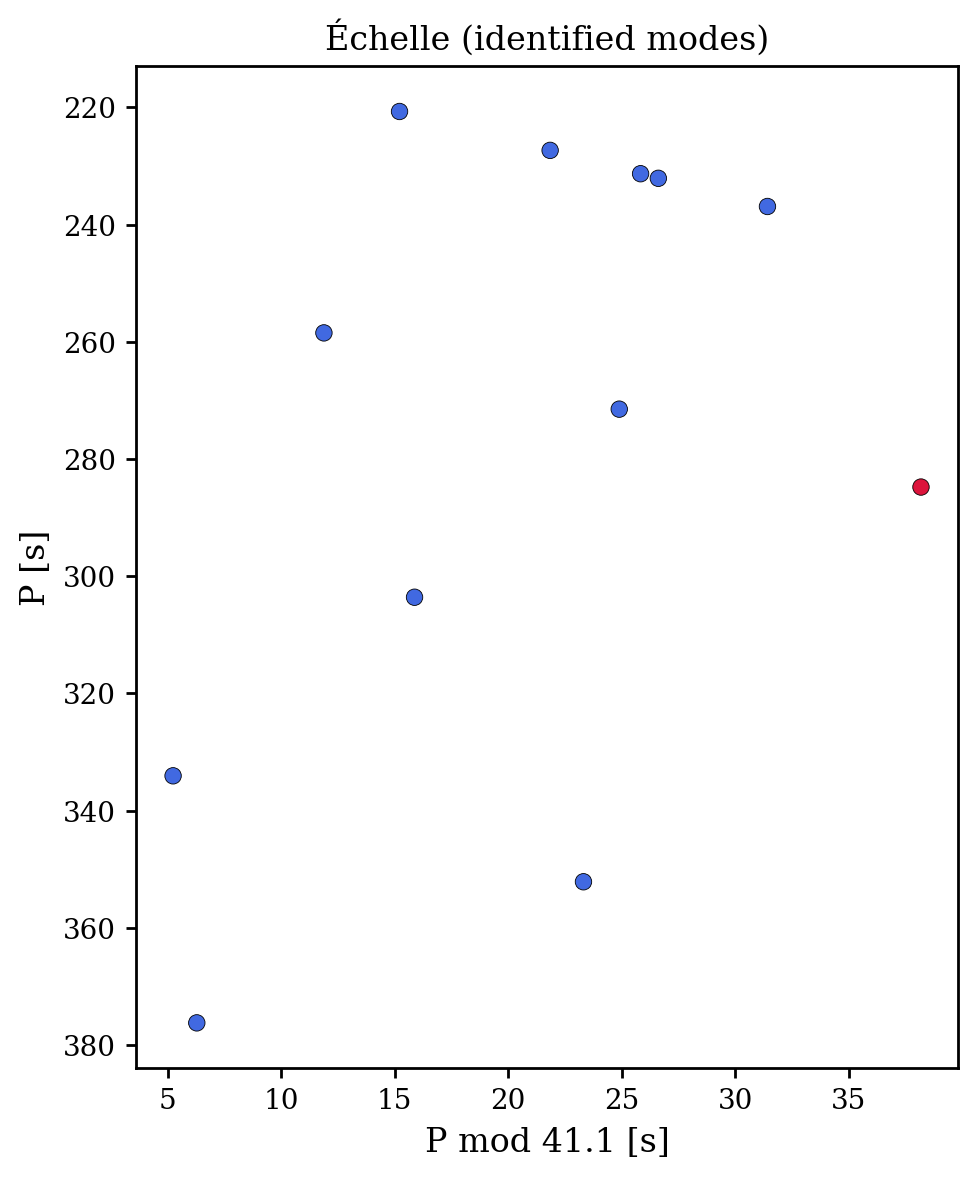

In [101]:
# requires your best ΔΠ1 in seconds: dP1_s
per_modes = 1e6 / modes_plot["nu_uHz"].to_numpy()          # s
x = np.mod(per_modes, dP1_s)
y = per_modes
c = [colors.get(ell_from_label(s), "tab:gray") for s in modes_plot["mode_label"]]

plt.figure(figsize=(5,6))
plt.scatter(x, y, c=c, s=35, edgecolor="k", lw=0.3)
plt.gca().invert_yaxis()
plt.xlabel(f"P mod {dP1_s:.1f} [s]")
plt.ylabel("P [s]")
plt.title("Échelle (identified modes)")
plt.tight_layout()
plt.show()


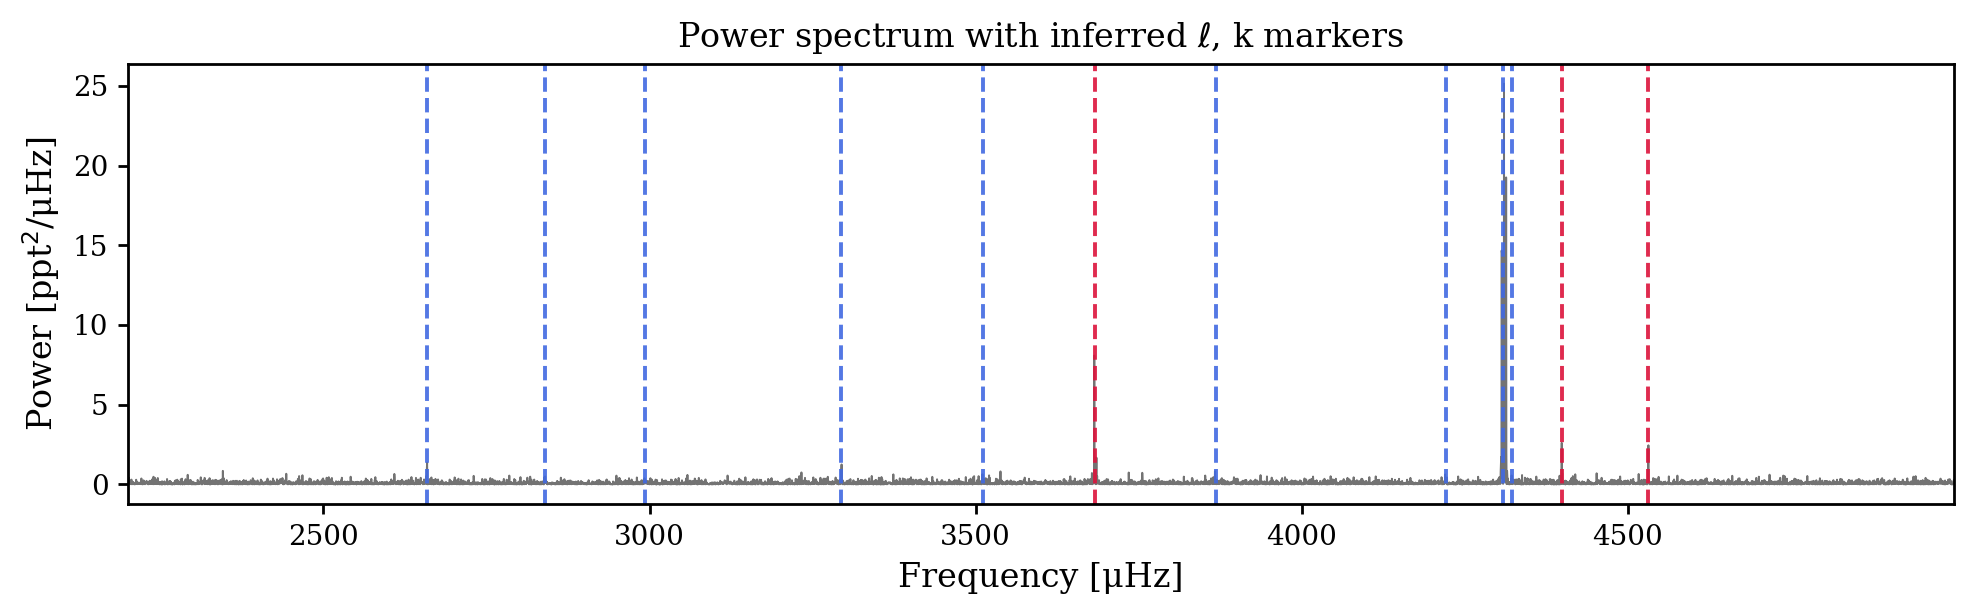

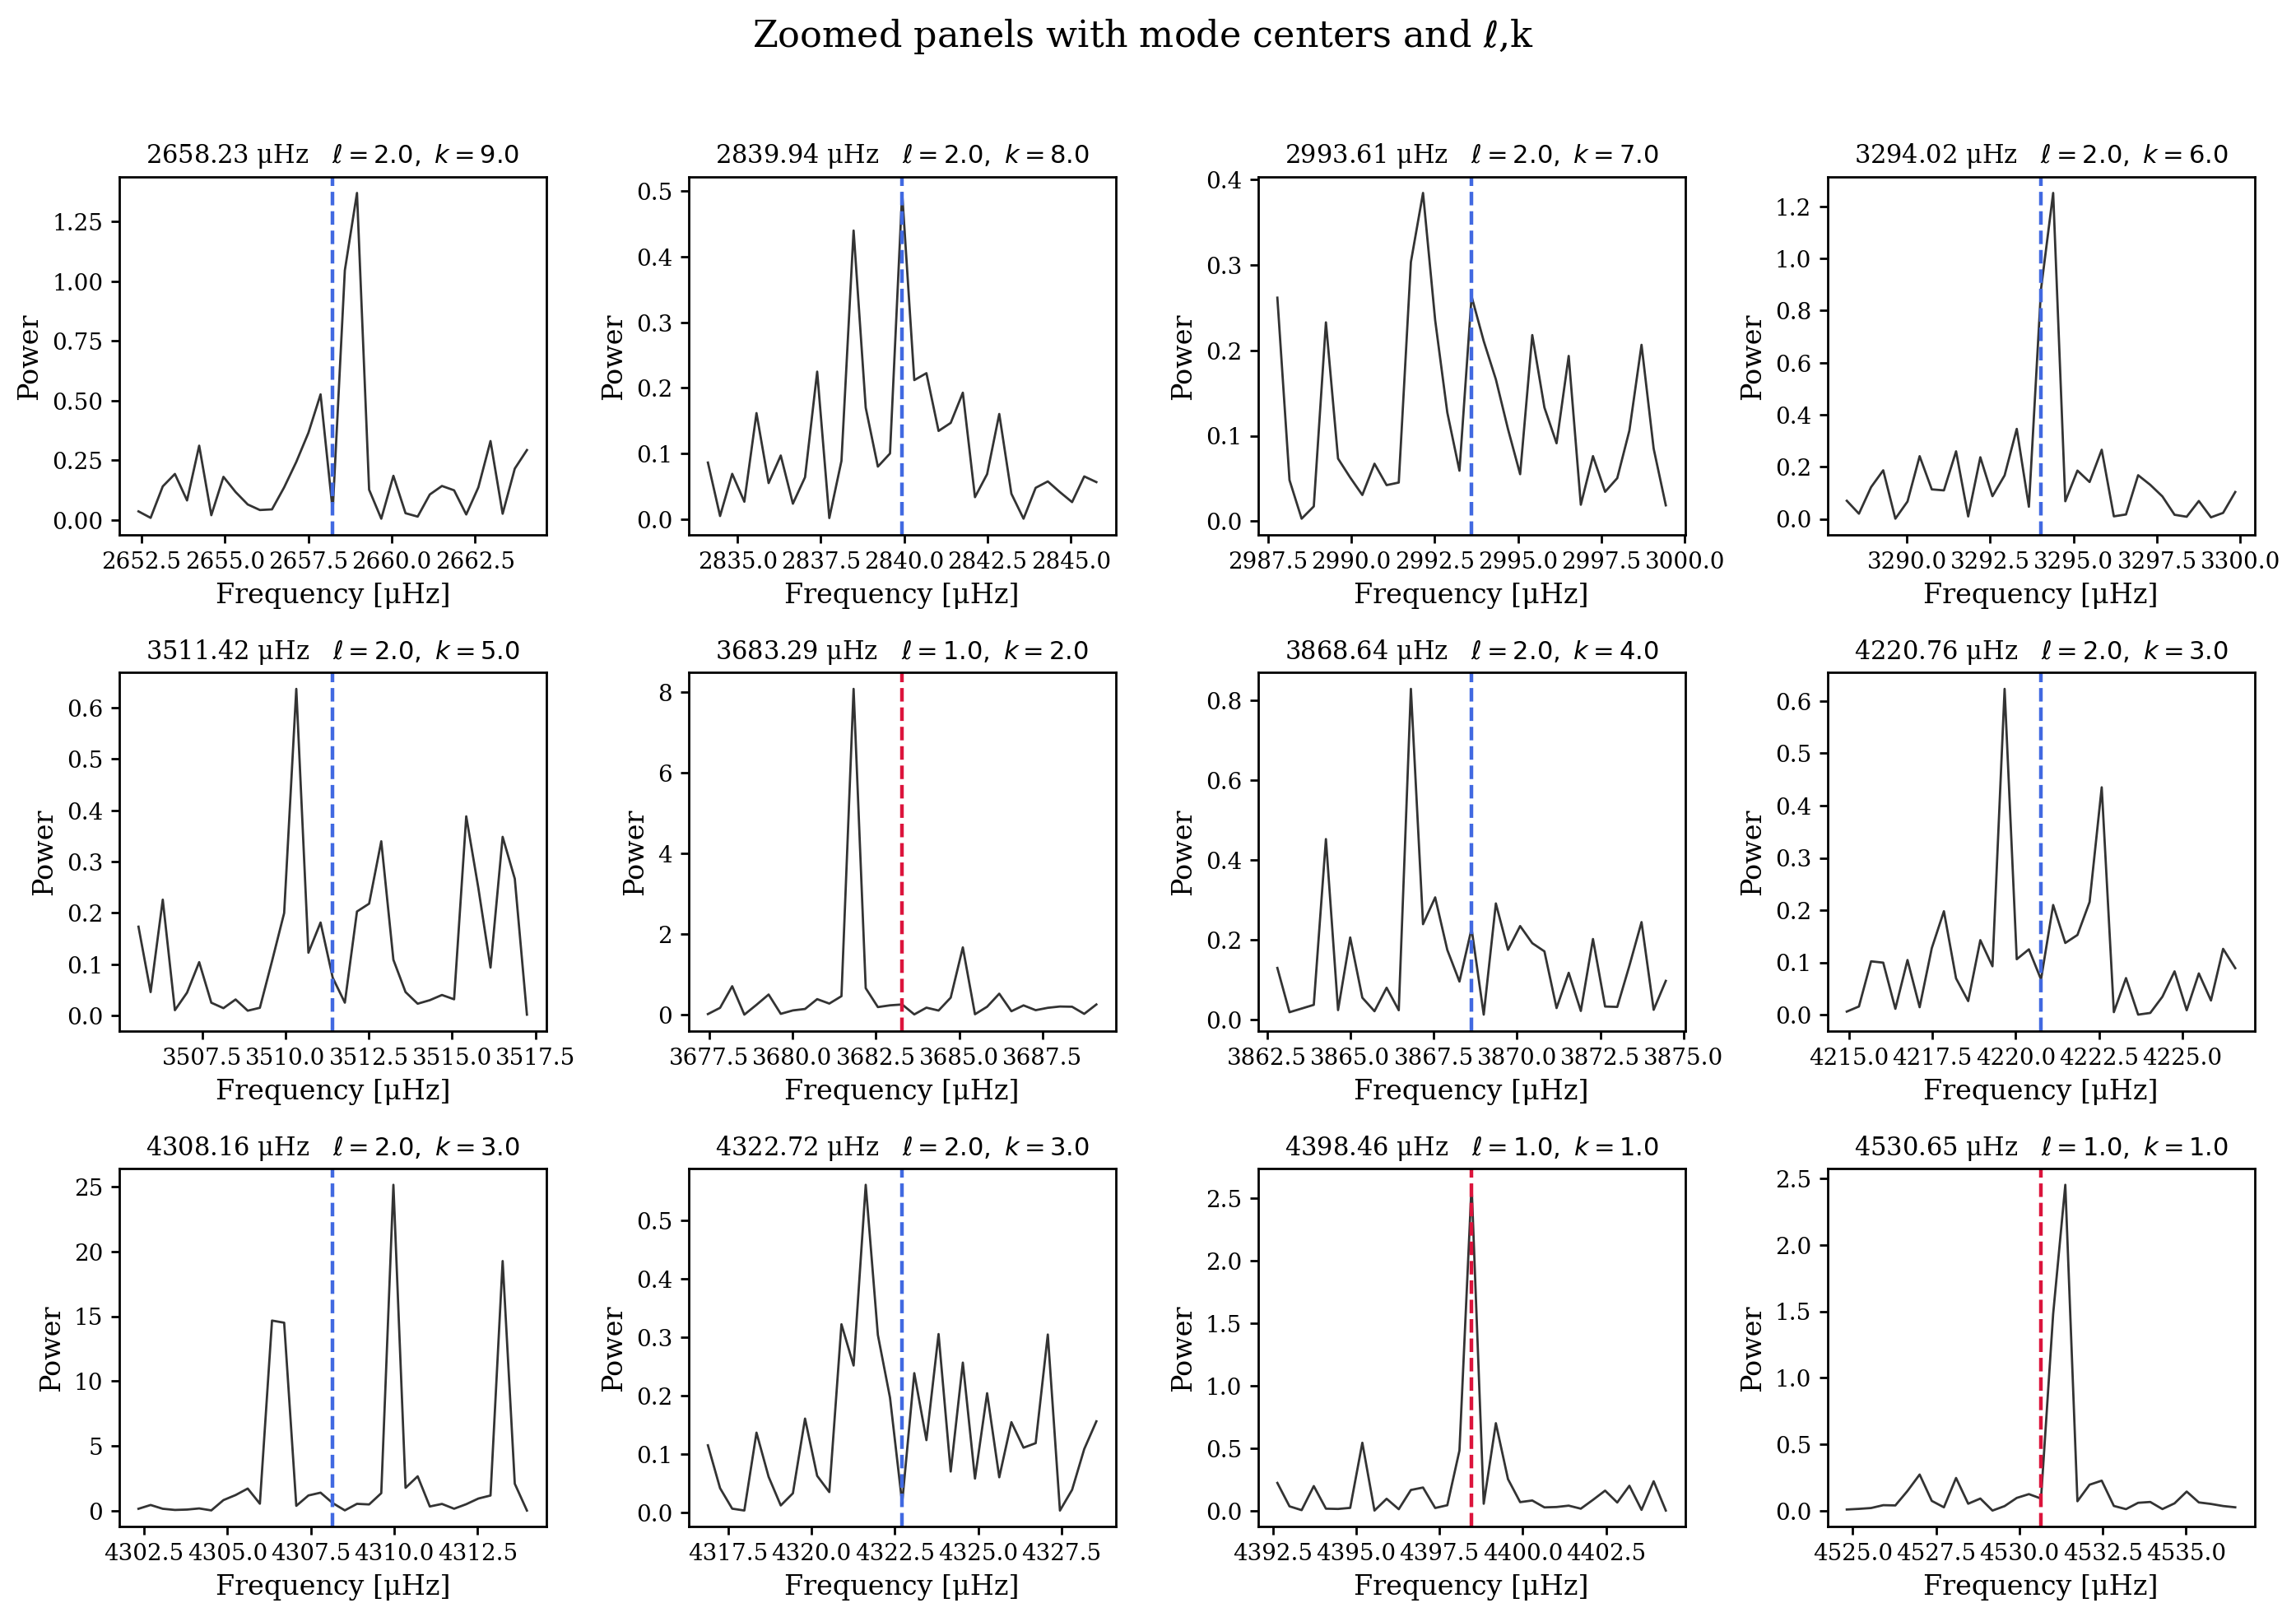

,nu_uHz,P_s,ell,k,resid_s
0,2658.232199,376.189860,2,9,0.306891
1,2839.938756,352.120269,2,8,-0.033604
2,2993.606426,334.045248,2,7,5.620470
3,3294.023078,303.580144,2,6,-1.115537
4,3511.415492,284.785438,2,5,3.818853
5,3683.290232,271.496390,1,2,3.043766
6,3868.638203,258.488891,2,4,1.251402
7,4220.762934,236.923991,2,3,3.415598
8,4308.156869,232.117824,2,3,-1.390569
9,4322.722525,231.335690,2,3,-2.172703


In [111]:
pmin, pmax = 150.0, 420.0    # seconds (adjust if needed)

# If you measured ΔΠ1 from your spacing spectrum, put it here:
dP1_s = 41.1                 # <-- update if your spacing estimate differs
dP2_s = dP1_s/np.sqrt(3.0)

# helpers
def refine_phi(periods_s, dP_s, pmin, pmax, weights=None, ngrid=2001):
    """Refine phase φ in [pmin, pmin+dP) by minimizing weighted wrapped distance."""
    P = np.asarray(periods_s, float)
    m = (P >= pmin) & (P <= pmax)
    P = P[m]; 
    if P.size == 0: 
        return pmin
    W = np.ones_like(P) if weights is None else np.asarray(weights, float)[m]
    phis = np.linspace(pmin, pmin + dP_s, ngrid, endpoint=False)
    scores = np.empty_like(phis)
    for i, phi in enumerate(phis):
        k = np.rint((P - phi)/dP_s)
        dist = P - (phi + k*dP_s)
        scores[i] = np.average(np.abs(dist), weights=W)
    return float(phis[np.argmin(scores)])

def comb_periods(dP_s, phi_s, pmin, pmax, kpad=800):
    phi_s = phi_s + dP_s * np.floor((pmin - phi_s)/dP_s + 1)
    ks = np.arange(-kpad, kpad+1)
    Pcomb = phi_s + ks*dP_s
    kk = ks[(Pcomb >= pmin) & (Pcomb <= pmax)]
    Pc = Pcomb[(Pcomb >= pmin) & (Pcomb <= pmax)]
    return Pc, kk

def nearest_combo(P, Pc):
    """return nearest comb location and residual for each P."""
    P = np.asarray(P, float)
    j = np.searchsorted(Pc, P)
    j0 = np.clip(j-1, 0, len(Pc)-1)
    j1 = np.clip(j,   0, len(Pc)-1)
    Pc_near = np.where(np.abs(P-Pc[j0]) <= np.abs(P-Pc[j1]), Pc[j0], Pc[j1])
    resid = P - Pc_near
    return Pc_near, resid

# ---- data in period space
Per = 1e6/np.asarray(centers_uHz, float)  # s
# fit φ separately for ℓ=1 and ℓ=2
phi1 = refine_phi(Per, dP1_s, pmin, pmax)
phi2 = refine_phi(Per, dP2_s, pmin, pmax)

# build combs in the plotting window
Pc1, k1 = comb_periods(dP1_s, phi1, pmin, pmax)
Pc2, k2 = comb_periods(dP2_s, phi2, pmin, pmax)

# assign each detected peak to whichever comb is closer
P_near1, r1 = nearest_combo(Per, Pc1)
P_near2, r2 = nearest_combo(Per, Pc2)

use_l1 = np.abs(r1) <= np.abs(r2)
ell   = np.where(use_l1, 1, 2)
P_ref = np.where(use_l1, P_near1, P_near2)
resid = np.where(use_l1, r1, r2)

# compute k (radial order index) for each assignment
k_for = np.empty_like(Per, dtype=int)
for i,(Pi, is_l1) in enumerate(zip(Per, use_l1)):
    if is_l1:
        k_for[i] = int(np.rint((P_ref[i]-phi1)/dP1_s))
    else:
        k_for[i] = int(np.rint((P_ref[i]-phi2)/dP2_s))

# tidy table
modes_id = pd.DataFrame({
    "nu_uHz": np.asarray(centers_uHz, float),
    "P_s":    Per,
    "ell":    ell,
    "k":      k_for,
    "resid_s": resid
}).sort_values("nu_uHz").reset_index(drop=True)

# (optional) mask out badly trapped outliers for the labels
mask_ok = np.abs(modes_id["resid_s"]) <= 7.0   # paper used ±7 s
modes_use = modes_id[mask_ok].copy()

# ---- plot like the paper: full band + zooms with labels
def lab(row):
    return fr"$\ell={row['ell']},\ k={row['k']}$"

# FULL band with dashed markers
fig, ax = plt.subplots(figsize=(10, 3.2))
ax.plot(f, P, color="0.45", lw=0.7)
for _, r in modes_use.iterrows():
    c = "crimson" if r["ell"]==1 else "royalblue"
    ax.axvline(r["nu_uHz"], color=c, ls="--", lw=1.4, alpha=0.9)
ax.set_xlim(f.min(), f.max())
ax.set_xlabel("Frequency [μHz]")
ax.set_ylabel("Power [ppt$^2$/μHz]")
ax.set_title("Power spectrum with inferred $\ell$, k markers")
plt.tight_layout()
plt.show()

# Small zoom panels (±6 μHz around each)
cols = 4
rows = int(np.ceil(len(modes_use)/cols))
fig, axes = plt.subplots(rows, cols, figsize=(14, 3.2*rows), sharey=False)
axes = np.atleast_1d(axes).ravel()
for ax, (_, r) in zip(axes, modes_use.iterrows()):
    nu0 = r["nu_uHz"]; c = "crimson" if r["ell"]==1 else "royalblue"
    w = 6.0
    m = (f >= nu0-w) & (f <= nu0+w)
    ax.plot(f[m], P[m], color="0.2", lw=1.0)
    ax.axvline(nu0, color=c, ls="--", lw=1.6)
    ax.set_title(f"{nu0:.2f} μHz   {lab(r)}", fontsize=11)
    ax.set_xlabel("Frequency [μHz]"); ax.set_ylabel("Power")
for ax in axes[len(modes_use):]:
    ax.axis("off")
plt.suptitle("Zoomed panels with mode centers and $\ell$,k", y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

display(modes_id)